# <center> K-Means, Hierarchical and DBSCAN Clustering on Amazon Fine Food Reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Split data into train and test using time based slicing as 70%  train & 30% test.
3.	Perform featurization BoW,TFIDF, Avg Word2Vec, tf-idf-Word2Vec.
4.	<b>K-Means ++ Clustering</b> :<br/>
    •	Find the best ‘k’ using elbow-knee method.<br/>
    •	Also find k sets and read through all the individual points in sets and evaluate that reviews make some sense or not.<br/>
    •	Also apply k-medoids algorithm as well.<br/>
5.	<b>Agglomerative Clustering</b> :<br/>
    •	Apply agglomerative algorithm and try different number of clusters like 2,5 etc.<br/>
    •	Also read through all the individual points in the clusters and evaluate that reviews make some sense or not.<br/>
    •	Note: Only take ~5000 reviews to perform hierarchical clustering because of high training complexity.<br/>
6.	<b>DBSCAN Clustering</b> :<br/>
    •	Apply DBSCAN algorithm and take MinPts = 2*d.<br/>
    •	Find the best ‘Eps’ using elbow-knee method.<br/>
    •	After finding the optimal ‘Eps’, try different values of ‘Eps’ to check the variations in clustering.<br/>
    •	Also read through all the individual points in the clusters and evaluate that reviews make some sense or not.<br/>
    •	Note: Take complete ~364K dataset and perform DBSCAN algorithm on Word2Vec vectorizers with 100-dimension.<br/>
7.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.




### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is an unsupervised learning task, where we have to analyze, transform data into BoW,TF-IDF,Avg Word2ec and TFIDF Word2Vec vectorizers and apply k-means++, agglomerative and DBSCAN algorithm to cluster them.<span>

---


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import traceback
import sqlite3
import itertools
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict  
from tqdm import tqdm
from prettytable import PrettyTable
from sklearn import preprocessing
from sklearn.externals import joblib
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from pyclustering.utils import calculate_distance_matrix
from pyclustering.cluster import kmedoids
from pyclustering.cluster import cluster_visualizer
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import AgglomerativeClustering

### Load dataset :

In [3]:
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# For Data Cleaning Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=1JXCva5vXdIPgHbfNdD9sgnySqELoVtpy
# dataset - https://drive.google.com/open?id=1IoDoTT8TfDu53N6cyKg6xVCU-FDPHyIF

# For Text Preporcessing Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=18-AkTzzEhCwM_hflIbDNBMAP-imX4k4i
# dataset - https://drive.google.com/open?id=1SfDwwXFhDpjgtfIE5O_E80SO89xRc8Sa

# Load dataset
def load_review_dataset(do_not_sample=True, sample_count=1):
    # Create connection object to load sqlite dataset
    connection = sqlite3.connect('finalDataSet.sqlite')

    # Load data into pandas dataframe.
    reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
    reviews_df = reviews_df.drop(columns=['index'])   
       
    # Sample dataset
    if do_not_sample == False:
        reviews_df = reviews_df.sample(sample_count)
        
    # Convert timestamp to datetime.
    reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

    # Sort the data on the basis of time.
    reviews_df = reviews_df.sort_values(by=['Time'])    
    
    return reviews_df


# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset(do_not_sample = False,sample_count = 40000)


# Make CleanedText as a dataset for clustering
CLEANED_TEXT = reviews_df['CleanedText'].values

print("Dataset Shape : \n",CLEANED_TEXT.shape)

Dataset Shape : 
 (40000,)


<br/><br/>

### Perform Featurization on Text Data :

#### Bag of Words (BoW) :

In [4]:
def perform_bow(reviews):
    # Instantiate CountVectorizer
    bow_count_vectorizer = CountVectorizer()

    # Tokenize and build vocab
    bow_count_vectorizer.fit(reviews)

    # Encode document
    bow_dtm = bow_count_vectorizer.transform(reviews)


    print("\nThe type of count vectorizer ",type(bow_dtm))
    print("The shape of data matrix ",bow_dtm.get_shape())
    print("The number of unique words in matrix ", bow_dtm.get_shape()[1])

    # Data Normalization
    # bow_dtm = preprocessing.normalize(bow_dtm)
    
    return bow_dtm,bow_count_vectorizer

#### Term Frequency - Inverse Document Frequency (TF-IDF) :

In [5]:
def perform_tfidf(reviews):
    # Instantiate TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

    # Tokenize and build vocab
    tfidf_vectorizer.fit(reviews)

    # Encode document
    tfidf_dtm = tfidf_vectorizer.transform(reviews)

    print("\nThe type of count vectorizer ",type(tfidf_dtm))
    print("The shape of train matrix ",tfidf_dtm.get_shape())
    print("The number of unique words in train matrix ", tfidf_dtm.get_shape()[1])

    # Data Normalization
    # tfidf_dtm = preprocessing.normalize(tfidf_dtm)
    
    return tfidf_dtm,tfidf_vectorizer

#### Average Word2Vec :

In [6]:
def perform_avg_word2vec(reviews):
    # Create our own Word2Vec model from training data.

    # Make list of list from data
    list_of_sentences=[]
    for sentence in reviews:
        list_of_sentences.append(sentence.split())


    print("Shape of data : ",reviews.shape)
    print("Number of sentences present in data : ",len(list_of_sentences))

    # Generate model
    w2v_model = Word2Vec(list_of_sentences,min_count=3,size=50, workers=6)

    # List of word in vocabulary 
    w2v_words = list(w2v_model.wv.vocab)
    print("Length of vocabulary : ",len(w2v_words))

    # Prepare vectorizer using word2vec model
    list_data = []
    for sentence in tqdm(list_of_sentences,unit=" sentence",desc='Average Word2Vec'):
    # for sentence in list_of_sentences:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        list_data.append(word_2_vec)

    avg_w2v = list_data

    print("\nLength of vectorizer : ",len(avg_w2v))    
        
    return avg_w2v,w2v_words

#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [7]:
def perform_tf_idf_word2vec(reviews):
    # Make list of list from data.      
    list_of_sentences=[]
    for sentence in reviews:
        list_of_sentences.append(sentence.split())


    # Generate model
    w2v_model = Word2Vec(list_of_sentences,min_count=3,size=50, workers=6)
    
    # List of word in vocabulary 
    w2v_words = list(w2v_model.wv.vocab)
    print("Length of vocabulary : ",len(w2v_words))

    # Instantiate TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

    # Tokenize and build vocab
    tfidf_vectorizer.fit(reviews)

    # Encode document
    data_matrix = tfidf_vectorizer.transform(reviews)

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names()

    # Dictionary with word as a key, and the idf as a value
    dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))

    # Prepare train vectorizer using trained word2vec model        
    list_data = []
    row = 0
    for sentence in tqdm(list_of_sentences,unit=" sentence",desc='TF-IDF Weighted Word2Vec'):
        word_2_vec = np.zeros(50)
        weight_tfidf_sum = 0
        for word in sentence:
            try:
                vec = w2v_model.wv[word]
                # dict_word_idf[word] = idf value of word in whole courpus
                # sentence.count(word) = tf valeus of word in this review
                tfidf_value =  dict_word_idf[word]*sentence.count(word)
                word_2_vec += (vec * tfidf_value)
                weight_tfidf_sum += tfidf_value
            except:
                pass
        if weight_tfidf_sum != 0:
            word_2_vec /= weight_tfidf_sum
        list_data.append(word_2_vec)
        row += 1

        
    tfidf_w2v = list_data

    print("\nLength of vectorizer : ",len(tfidf_w2v))
    
    return tfidf_w2v,w2v_words

<br/>

#   * Unsupervised Learning * 
<br/>


### .................................... : K-Means++ Algorithm : ....................................

In [30]:
# Ideal values of k-clusters
k_clusters = [2,3,4,5,6,7,8,9,10]

dist_from_centroids = []

def perform_kmeans(X):
    dist_from_centroids = []   
    
    for k_value in tqdm(k_clusters,unit=" k-values",desc='Perform K-Means'):        
        # Instantiate KMeans
        kmeans = KMeans(n_clusters= k_value,n_jobs=-1)

        # Fit model to data
        kmeans.fit(X)

        # Save data for plotting
        dist_from_centroids.append(kmeans.inertia_)        
       
    return k_clusters,dist_from_centroids
    
def plot_elbow(k_clusters,dist_from_centroids):
    print()
    print()
    # plot Sum of squared distances of samples to their closest cluster center vs 'K' value
    
    # Plot the elbow
    plt.plot(np.array(k_clusters), np.array(dist_from_centroids), 'bx-')
    plt.xlabel('K')
    plt.ylabel('Distance From Centroids')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


def get_kmeans_clusters(kmeans):
    cluster_label_reviews = dict()
    for i in range(0,kmeans.n_clusters):
        cluster_label_reviews[i] = []
        
    
    for i in range(kmeans.labels_.shape[0]):
        holder = list()
        holder.append(CLEANED_TEXT[i]) 
        temp = cluster_label_reviews[kmeans.labels_[i]] + holder
        cluster_label_reviews[kmeans.labels_[i]] = temp
    
    return cluster_label_reviews

def print_cluster_reviews(cluster_label_reviews,cluster_number = 0,review_count=3):
    reviews = cluster_label_reviews[cluster_number]
    reviews = reviews[0:review_count]
    print("---: Cluster {0} :---".format(cluster_number))
    index = 1
    for review in reviews:
        print("Review {0} : ".format(index))
        print(review)
        print()
        index += 1


def plot_word_cloud(review):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(review[0]) 
            
      
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
    
def plot_kmeans_clusters(kmeans,data_matrix,label_color_map):
    print()
    svd = TruncatedSVD(n_components=2)
    data_matrix_2_dim = svd.fit_transform(data_matrix) 

    # Compute cluster centers and predict cluster indices
    cluster_labels = kmeans.fit_predict(data_matrix_2_dim)

    # Define our own color map    
    label_color = [label_color_map[l] for l in cluster_labels]
    
    # Plot the scatter digram
    plt.figure(figsize = (12,10))
    for index in range(0,len(label_color)) :
        label_name = list(label_color_map.keys())[list(label_color_map.values()).index(label_color[index])]        
        plt.scatter(data_matrix_2_dim[index,0],data_matrix_2_dim[index,1], c= label_color[index],label=label_name, alpha=0.8) 
    plt.xlabel("Component 1")
    plt.ylabel("Component 2") 
    plt.title("K-Means Clustering on Reviews") 
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles)) 
    plt.legend(by_label.values(), by_label.keys())
    plt.show()   
    

#### K-Means++ on BoW


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of data matrix  (40000, 27970)
The number of unique words in matrix  27970


Perform K-Means: 100%|███████████████████████████████████████████████████████████| 9/9 [37:25<00:00, 304.98s/ k-values]


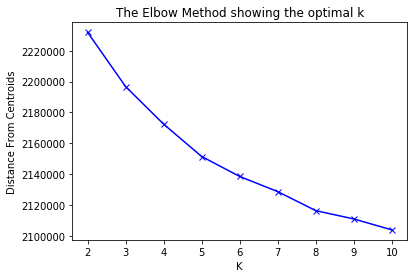

Wall time: 37min 27s


In [30]:
%%time

# Vectorize text data to numerical vector
bow_dtm,bow_count_vectorizer = perform_bow(CLEANED_TEXT)

# Perform K-Means++
k_clusters,dist_from_centroids = perform_kmeans(bow_dtm)

# Plot K and distance to get optimal K
plot_elbow(k_clusters,dist_from_centroids)

At K=8, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=8.

In [31]:
# Lets perfrom K-Means using optimal K value
kmeans = KMeans(n_clusters=8, n_jobs=-1)
kmeans = kmeans.fit(bow_dtm)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
# Get clusters of reviews with cluster label 
cluster_label_reviews = get_kmeans_clusters(kmeans)

# Length of reviews present in clusters
for cluster_label, review in cluster_label_reviews.items():
    print("Cluster {0} : Number of Reviews {1}".format(cluster_label,len(review)))

Cluster 0 : Number of Reviews 2072
Cluster 1 : Number of Reviews 26062
Cluster 2 : Number of Reviews 165
Cluster 3 : Number of Reviews 1168
Cluster 4 : Number of Reviews 1001
Cluster 5 : Number of Reviews 329
Cluster 6 : Number of Reviews 8330
Cluster 7 : Number of Reviews 873


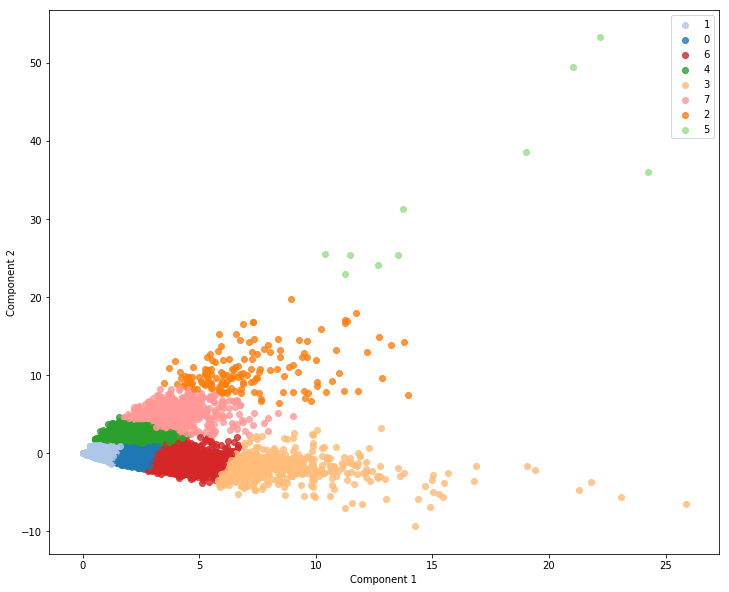

In [68]:
# Color map
cluster_colors = {0: '#1f77b4', 1: '#aec7e8', 2: '#ff7f0e', 3: '#ffbb78', 4: '#2ca02c',
                  5: '#98df8a', 6: '#d62728', 7: '#ff9896'}

# Plot clusters
plot_kmeans_clusters(kmeans,bow_dtm,cluster_colors)

In [72]:
# Print n reviews from cluster, lets say 3, i.e. cluster 2
cluster_number = 2
review_count = 5
print_cluster_reviews(cluster_label_reviews,cluster_number = cluster_number, review_count = review_count)

---: Cluster 2 :---
Review 1 : 
stori two tazo tea found almost need one anoth produc tea except qualiti tri tea separ final blend togeth tazo lotus tazo wild sweet orang make wonder lemoni hot tea winter enjoy toss ice cube summer way make tea steep two lotus two wild sweet orang filterbag ounc water make coffe maker plenti time flavor seep steam water add tablespoon orang blossom honey hot tea bit ice tea drink blend aromat experi lotus decaffein green tea blend natur decaffein green tea natur lotus flower flavor natur flavor wild sweet orang blend lemongrass blackberri leav citric acid rose hip spearmint leav natur flavor orang peel safflow hibiscus flower rose petal natur orang essenc ginger root licoric root love crink sound paper bag protect precious content box also quit intrigu stori tea packet alway mysteri play romant tea color never decid like best hot cold end drink hot cold half ice half mug tea hot much romant aromat chill take bitter compon someth even exot tri tazo gree

Review 1: 


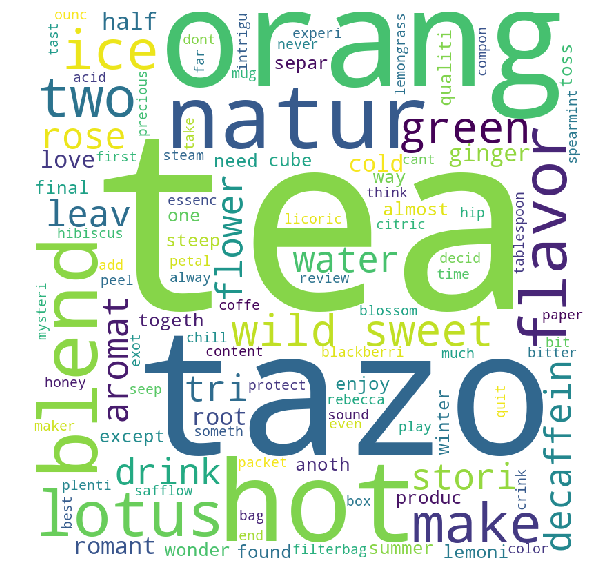



Review 2: 


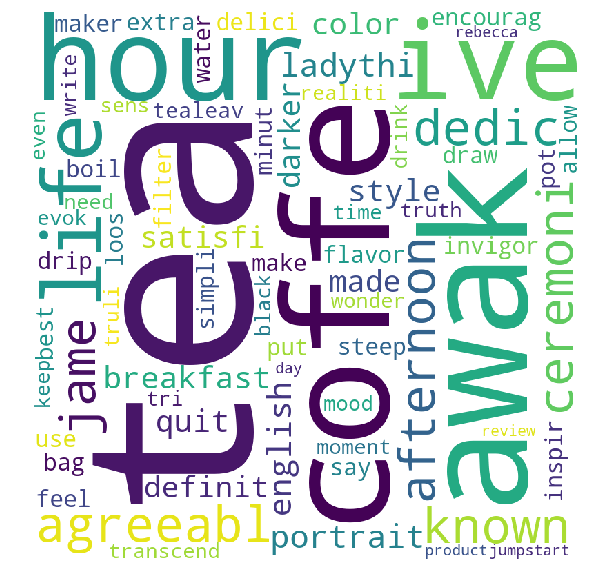



Review 3: 


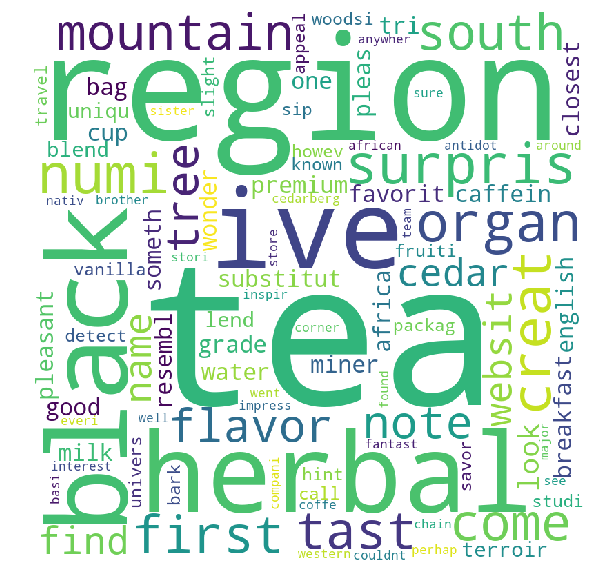

In [81]:
# Plot word cloud review 1
print("Review 1: ")
plot_word_cloud(cluster_label_reviews[cluster_number][0:1])

# Plot word cloud review 2
print("\n\nReview 2: ")
plot_word_cloud(cluster_label_reviews[cluster_number][1:2])

# Plot word cloud review 3
print("\n\nReview 3: ")
plot_word_cloud(cluster_label_reviews[cluster_number][2:3])

<br/>
<br/>

#### K-Means++ on TF-IDF


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (40000, 100422)
The number of unique words in train matrix  100422


Perform K-Means: 100%|█████████████████████████████████████████████████████████| 9/9 [1:32:07<00:00, 659.39s/ k-values]


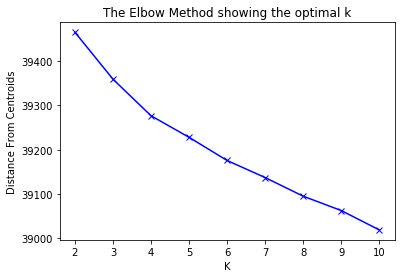

In [82]:
# Vectorize text data to numerical vector
tfidf_dtm,tfidf_vectorizer = perform_tfidf(CLEANED_TEXT)

# Perform K-Means++
k_clusters,dist_from_centroids = perform_kmeans(tfidf_dtm)

# Plot K and distance to get optimal K
plot_elbow(k_clusters,dist_from_centroids)

At K=4, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=4.

In [84]:
# Lets perfrom K-Means using optimal K value
kmeans = KMeans(n_clusters=4, n_jobs=-1)
kmeans = kmeans.fit(tfidf_dtm)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [86]:
# Get clusters of reviews with cluster label 
cluster_label_reviews = get_kmeans_clusters(kmeans)

# Length of reviews present in clusters
for cluster_label, review in cluster_label_reviews.items():
    print("Cluster {0} : Number of Reviews {1}".format(cluster_label,len(review)))

Cluster 0 : Number of Reviews 3201
Cluster 1 : Number of Reviews 3442
Cluster 2 : Number of Reviews 30869
Cluster 3 : Number of Reviews 2488


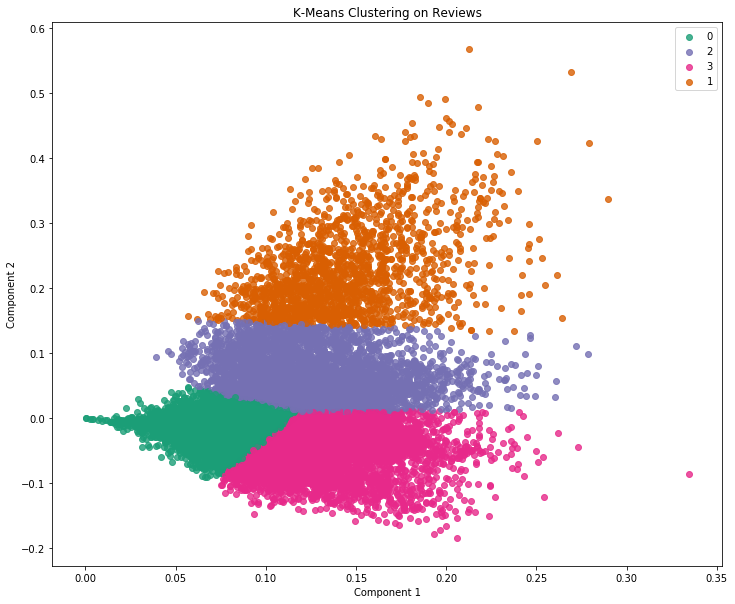

In [88]:
# Color map
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

# Plot clusters
plot_kmeans_clusters(kmeans,tfidf_dtm,cluster_colors)

In [89]:
# Print n reviews from cluster, lets say 3, i.e. cluster 2
cluster_number = 2
review_count = 5
print_cluster_reviews(cluster_label_reviews,cluster_number = cluster_number, review_count = review_count)

---: Cluster 2 :---
Review 1 : 
get crazi look beatlejuic french version video realli imposs today find french vhs version film could pleas tell someth tks

Review 2 : 
recent purchas woodstream corp gopher trap within minut lay trap catch gopher product best ever use gopher trap easi set work great success also rememb use wire attach trap tie steak prevent gopher drag trap hole caught hope find product easi use good luck

Review 3 : 
dont know anyon would ever use littl liquid food color tri past color intens easili blend love shade ice martha stewart show wonder season cooki time time show simpl ice cooki excit color make wonder tabl decor well great dessert parti tea event past color must like make frost cooki parti cake especi fun kid contest fun event birthday parti christma parti raini afternoon

Review 4 : 
spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi n

Review 1: 


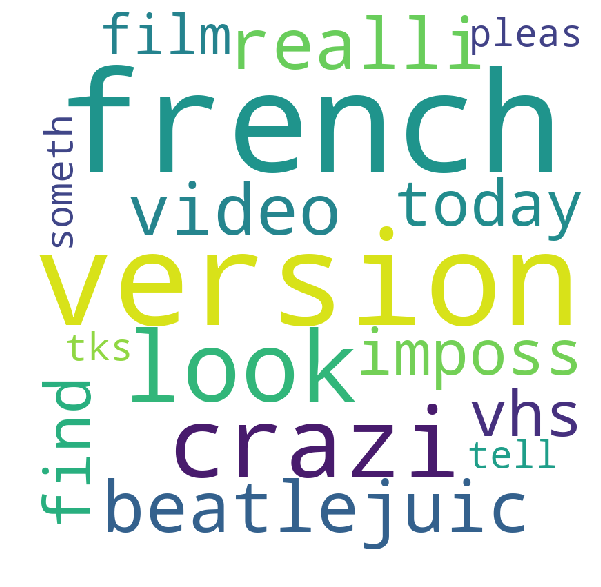



Review 2: 


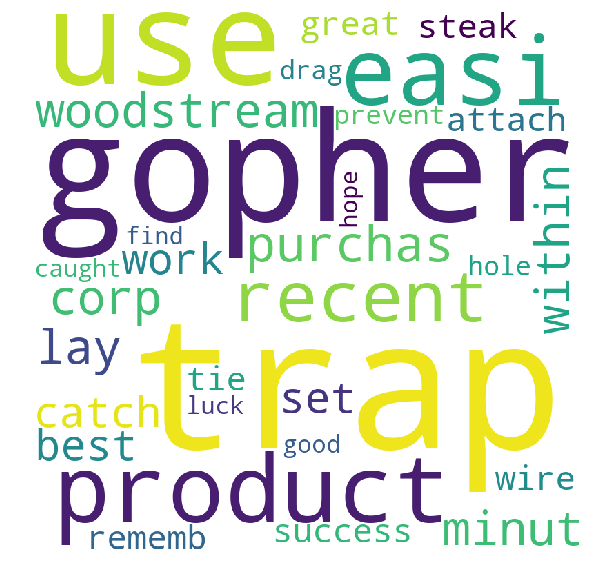



Review 3: 


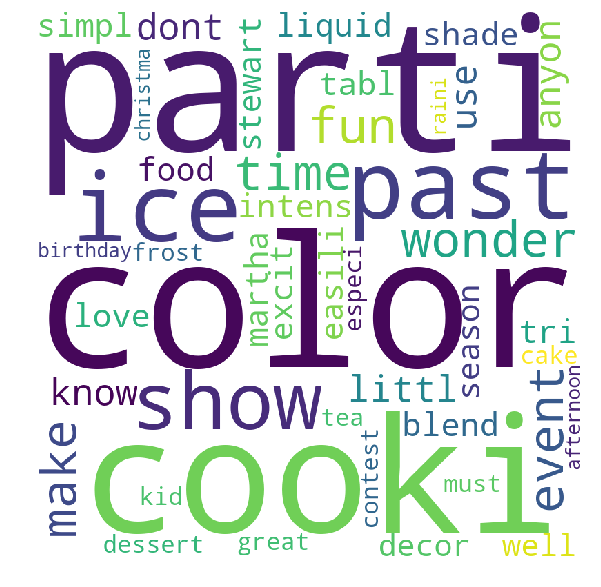

In [90]:
# Plot word cloud review 1
print("Review 1: ")
plot_word_cloud(cluster_label_reviews[cluster_number][0:1])

# Plot word cloud review 2
print("\n\nReview 2: ")
plot_word_cloud(cluster_label_reviews[cluster_number][1:2])

# Plot word cloud review 3
print("\n\nReview 3: ")
plot_word_cloud(cluster_label_reviews[cluster_number][2:3])

<br/>
<br/>

#### K-Means++ on Average Word2Vec

Shape of data :  (40000,)
Number of sentences present in data :  40000
Length of vocabulary :  11020


Average Word2Vec: 100%|█████████████████████████████████████████████████| 40000/40000 [00:32<00:00, 1214.86 sentence/s]



Length of vectorizer :  40000


Perform K-Means: 100%|████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  5.39s/ k-values]


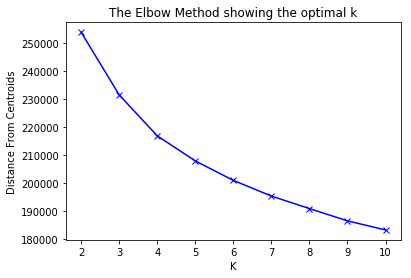

In [91]:
# Vectorize text data to numerical vector
avg_word2vec,avg_word2vec_words = perform_avg_word2vec(CLEANED_TEXT)

# Perform K-Means++
k_clusters,dist_from_centroids = perform_kmeans(avg_word2vec)

# Plot K and distance to get optimal K
plot_elbow(k_clusters,dist_from_centroids)

At K=7, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=7.

In [92]:
# Lets perfrom K-Means using optimal K value
kmeans = KMeans(n_clusters=7, n_jobs=-1)
kmeans = kmeans.fit(avg_word2vec)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [95]:
# Get clusters of reviews with cluster label 
cluster_label_reviews = get_kmeans_clusters(kmeans)

# Length of reviews present in clusters
for cluster_label, review in cluster_label_reviews.items():
    print("Cluster {0} : Number of Reviews {1}".format(cluster_label,len(review)))

Cluster 0 : Number of Reviews 5700
Cluster 1 : Number of Reviews 4598
Cluster 2 : Number of Reviews 6326
Cluster 3 : Number of Reviews 5033
Cluster 4 : Number of Reviews 4071
Cluster 5 : Number of Reviews 8109
Cluster 6 : Number of Reviews 6163


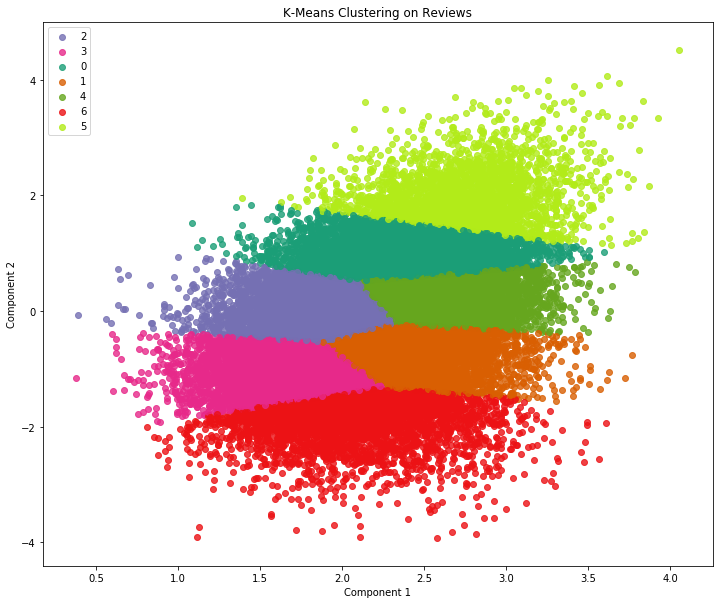

In [97]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#B2EB19',
                  6: '#EC1215'
                  } 

# Plot clusters
plot_kmeans_clusters(kmeans,avg_word2vec,cluster_colors)

In [98]:
# Print n reviews from cluster, lets say 3, i.e. cluster 2
cluster_number = 2
review_count = 5
print_cluster_reviews(cluster_label_reviews,cluster_number = cluster_number, review_count = review_count)

---: Cluster 2 :---
Review 1 : 
product remind thousand lunch chicken teriyaki mound steam rice eat drizzl soy food home make everyday teriyaki day

Review 2 : 
love sauc put everyth

Review 3 : 
forget store bought jerki make premium jerki american spice hot beef jerki blend regular call mix dont stand product could give six star would

Review 4 : 
usual purchas item smaller link pound stash freezer perfect dinner thaw microwav toss grill pan brown meanwhil make salad green side saut can cannellini bean herb garlic whip instant polenta made creami goat chees break open crusti loaf bread minut tabl ultim comfort food leftov sausag get dice pasta sauc plenti spice present peopl usual shun hot pepperi food like

Review 5 : 
sauc excel inde spici brand also make mild version addit wonder product like rib rub made north carolina husband doesnt like sweeter type bbq sauc brand love



Review 1: 


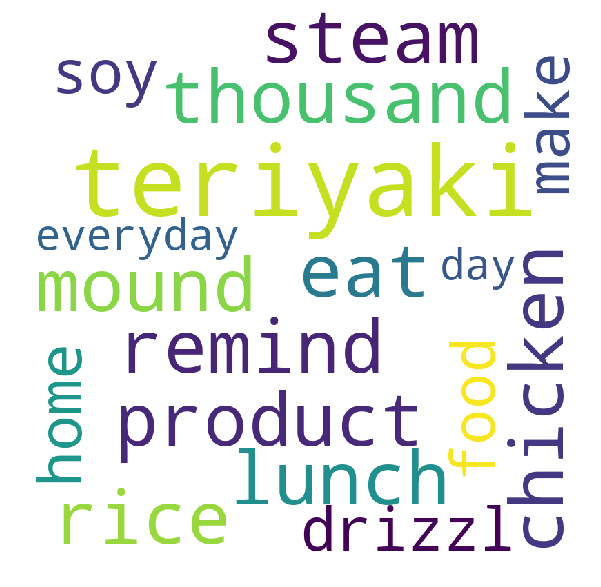



Review 2: 


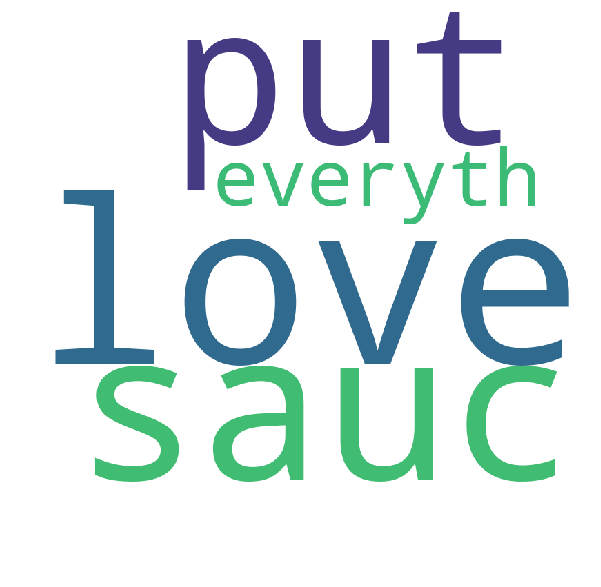



Review 3: 


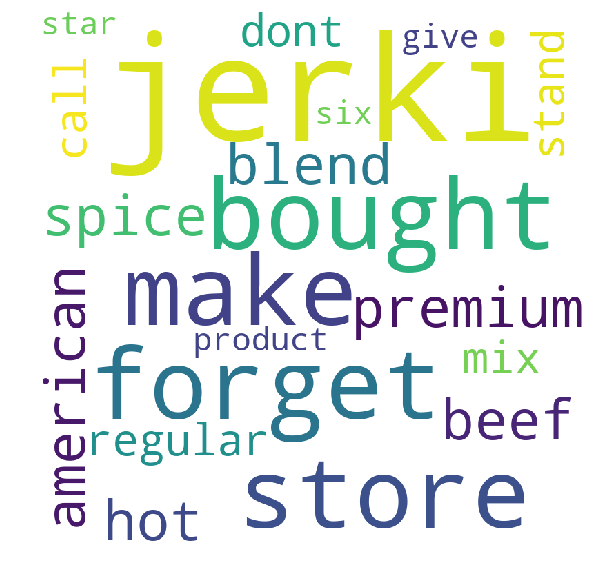

In [99]:
# Plot word cloud review 1
print("Review 1: ")
plot_word_cloud(cluster_label_reviews[cluster_number][0:1])

# Plot word cloud review 2
print("\n\nReview 2: ")
plot_word_cloud(cluster_label_reviews[cluster_number][1:2])

# Plot word cloud review 3
print("\n\nReview 3: ")
plot_word_cloud(cluster_label_reviews[cluster_number][2:3])

<br/>
<br/>

#### K-Means++ on TF-IDF Weighted Word2Vec

Length of vocabulary :  11020


TF-IDF Weighted Word2Vec: 100%|█████████████████████████████████████████| 40000/40000 [00:11<00:00, 3620.08 sentence/s]



Length of vectorizer :  40000


Perform K-Means: 100%|████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  4.84s/ k-values]


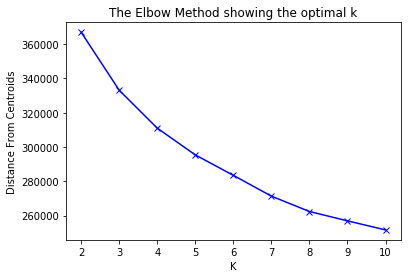

In [100]:
# Vectorize text data to numerical vector
tf_idf_word2vec,tf_idf_word2vec_words = perform_tf_idf_word2vec(CLEANED_TEXT)

# Perform K-Means++
k_clusters,dist_from_centroids = perform_kmeans(tf_idf_word2vec)

# Plot K and distance to get optimal K
plot_elbow(k_clusters,dist_from_centroids)

At K=7, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=7.

In [101]:
# Lets perfrom K-Means using optimal K value
kmeans = KMeans(n_clusters=7, n_jobs=-1)
kmeans = kmeans.fit(tf_idf_word2vec)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [102]:
# Get clusters of reviews with cluster label 
cluster_label_reviews = get_kmeans_clusters(kmeans)

# Length of reviews present in clusters
for cluster_label, review in cluster_label_reviews.items():
    print("Cluster {0} : Number of Reviews {1}".format(cluster_label,len(review)))

Cluster 0 : Number of Reviews 5498
Cluster 1 : Number of Reviews 3925
Cluster 2 : Number of Reviews 1530
Cluster 3 : Number of Reviews 7980
Cluster 4 : Number of Reviews 2811
Cluster 5 : Number of Reviews 11535
Cluster 6 : Number of Reviews 6721


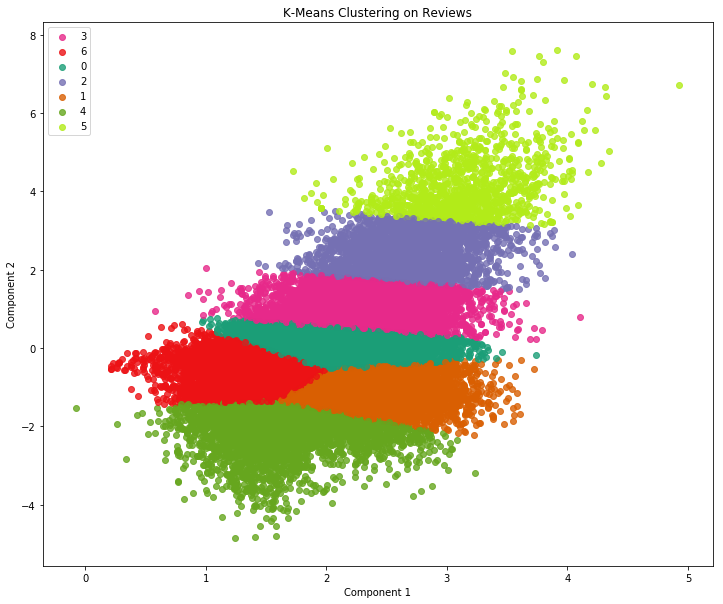

In [103]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#B2EB19',
                  6: '#EC1215'
                  } 

# Plot clusters
plot_kmeans_clusters(kmeans,tf_idf_word2vec,cluster_colors)

In [104]:
# Print n reviews from cluster, lets say 3, i.e. cluster 2
cluster_number = 2
review_count = 5
print_cluster_reviews(cluster_label_reviews,cluster_number = cluster_number, review_count = review_count)

---: Cluster 2 :---
Review 1 : 
case tea mellow yet flavor pleasant tea perfect time want relax great bed time long day work help unwind typic experi brand aroma pleasant complex easili qualifi singl best tea ive ever immens pleasur enjoy

Review 2 : 
huge tea fan thrill see melitta make tea pod use new pressur coffe maker ive got senseo pod work fine assum also use similar maker tea great brew process ensur get nice dark flavor cup love see flavor eventu especi orang spice black tea pod along flavor honey stick stash tea trick high recommend tea drinker brewer

Review 3 : 
unquestion refin tea darjeel come region indian west bengales himalaya close nepales border sea level origin privat centuri plantat british civil surgeon name campbel tea long sinc transform region major econom center run garden produc million kgs million lbs tea total area almost hectar approxim squar mile employ peopl perman basi hire pluck season march novemb area natur climat mixtur rainfal sunshin rich soil mak

Review 1: 


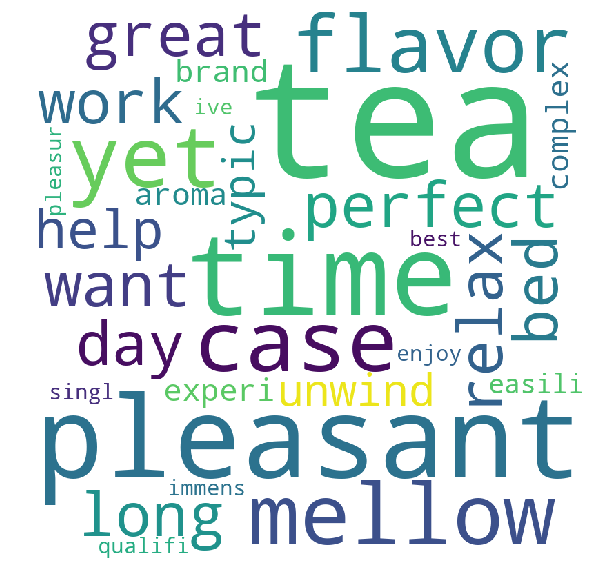



Review 2: 


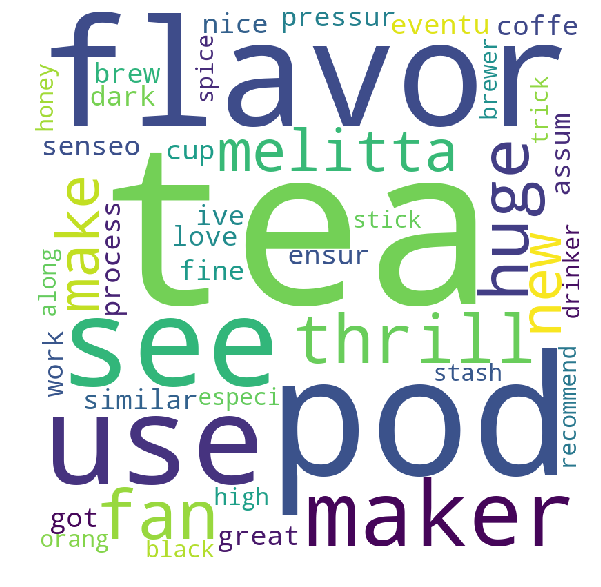



Review 3: 


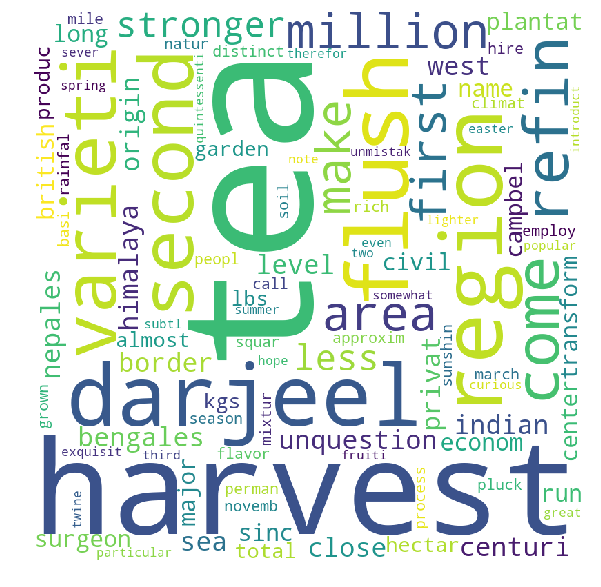

In [105]:
# Plot word cloud review 1
print("Review 1: ")
plot_word_cloud(cluster_label_reviews[cluster_number][0:1])

# Plot word cloud review 2
print("\n\nReview 2: ")
plot_word_cloud(cluster_label_reviews[cluster_number][1:2])

# Plot word cloud review 3
print("\n\nReview 3: ")
plot_word_cloud(cluster_label_reviews[cluster_number][2:3])

<br/>
<br/>

###  .................................... : K-Medoids Algorithm : ....................................

#### To perform k-medoids algorithm on text data, we will use pyclustering library which has implementation of k-medoids (PAM).

for more details go to https://github.com/annoviko/pyclustering

In [39]:
# Load 'finalDataSet.sqlite' in panda's daraframe.Data took ~50K
reviews_df = load_review_dataset(do_not_sample = False,sample_count = 50000)


# Make CleanedText as a dataset for clustering
CLEANED_TEXT = reviews_df['CleanedText'].values

print("Dataset Shape : \n",CLEANED_TEXT.shape)

def print_cluster_reviews_k_medoids(cluster_label_reviews,cluster_number = 0,review_count=3):
    reviews = cluster_label_reviews[cluster_number]
    reviews = reviews[0:review_count]
    print("---: Cluster {0} :---".format(cluster_number))
    index = 1
    for review in reviews:
        print("Review {0} : ".format(index))
        print(CLEANED_TEXT[review])
        print()
        index += 1


def perform_k_medoids(data, starting_medoids_points, tolerence):
    # Create K-Medoids class instance for processing data
    k_medoids = kmedoids.kmedoids(data, starting_medoids_points,tolerence,ccore=True)

    # Run cluster analysis and obtain results
    k_medoids.process()
                      
    return k_medoids

def get_cluster_N_medoids(k_medoids):    
    return k_medoids.get_clusters(),k_medoids.get_medoids()

def plot_k_medoids(data_2_dim,starting_medoids_points,clusters,medoids):
    # Visualize clusters
    # For single canvas
    visualizer = cluster_visualizer(1)

    # Add x and y data to visualizer
    visualizer.append_clusters(clusters, data_2_dim, 0)

    # Show Starting medoid points as a triangle
    visualizer.append_cluster([ data_2_dim[index] for index in starting_medoids_points ], marker = '^', markersize = 15)

    # Show calculated medoids as a star
    visualizer.append_cluster(medoids, data=data_2_dim, marker='*', markersize=15);
    visualizer.show();    
    

Dataset Shape : 
 (50000,)


<br/>

#### K-Medoids on BoW

In [40]:
# Vectorize text data to numerical vector
bow_dtm,bow_count_vectorizer = perform_bow(CLEANED_TEXT)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of data matrix  (50000, 31093)
The number of unique words in matrix  31093


In [41]:
# Perform dimensionality reduction.
svd = TruncatedSVD(n_components=2)
bow_dtm_2_dim = svd.fit_transform(bow_dtm)
bow_dtm_2_dim.shape

(50000, 2)

In [42]:
# Starting points for medoids
starting_medoids_points = [2, 9, 12]

# Tolerence value for convergence
tolerence = 0.001

In [43]:
%%time

# Perform K-Medoids
k_medoids = perform_k_medoids(bow_dtm_2_dim, starting_medoids_points, tolerence)

Wall time: 54min 25s


In [44]:
# Get cluster and medoids
clusters,medoids =  get_cluster_N_medoids(k_medoids)

In [45]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))         

Number of Reviews in Cluster 0 : 40315 
Number of Reviews in Cluster 1 : 1678 
Number of Reviews in Cluster 2 : 8007 


In [46]:
# Print n reviews
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
popcorn tast great pop realli nice like fresh know arent get corn worth extra money

Review 2 : 
twist rumplestiskin captur film star michael keaton geena davi prime tim burton masterpiec rumbl absurd wonder pace point dull moment

Review 3 : 
happen say name three time michael keaten star comedi two coupl live old two stori hous come back suppli store coupl sudden get caught insid bridg start tumbl lake board catch theyv got hope small dog step board car start slide bridg lake water minut later find back home find somehow somehad light fireplac done magic find dead guy known bettlejuic way get help call name three time appear survic soon wish never call name bettlejuic troublemak one save account said name three time cant leav hous els find theirselv anoth world giant sandworm stellar comedi see michael keaton awesom play lead role bettlejuic




---: Cluster 1 :---
Review 1 : 
review definit give inform type purpos review recommend favorit tea drink ev

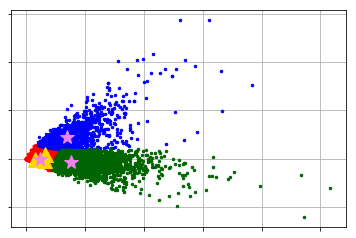

In [47]:
# Plot clusters
plot_k_medoids(bow_dtm_2_dim, starting_medoids_points, clusters, medoids)

#### Here Triangle(^) marker are user defined medoids and Star(*) markers are calculated medoids by k-medoids algorithm.

<br/>
<br/>

#### K-Medoids on TF-IDF

In [48]:
# Vectorize text data to numerical vector
tfidf_dtm,tfidf_vectorizer = perform_tfidf(CLEANED_TEXT)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (50000, 122440)
The number of unique words in train matrix  122440


In [49]:
# Perform dimensionality reduction.
svd = TruncatedSVD(n_components=2)
tfidf_dtm_2_dim = svd.fit_transform(tfidf_dtm)
tfidf_dtm_2_dim.shape

(50000, 2)

In [50]:
# Starting points for medoids
starting_medoids_points = [2, 9, 12]

# Tolerence value for convergence
tolerence = 0.001

In [51]:
%%time

# Perform K-Medoids
k_medoids = perform_k_medoids(tfidf_dtm_2_dim, starting_medoids_points, tolerence)

Wall time: 48min 48s


In [52]:
# Get cluster and medoids
clusters,medoids =  get_cluster_N_medoids(k_medoids)

In [53]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices))) 

Number of Reviews in Cluster 0 : 4320 
Number of Reviews in Cluster 1 : 6454 
Number of Reviews in Cluster 2 : 39226 


In [54]:
# Print n reviews
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
notori earli album camper van beethoven get present cds come cardboard singl sleev price except cheap there live album also includ lengthi booklet essay santa cruz colleg rocker lifestyl earli camper cvb fan sure thing godsend didnt snap earli print first album curious camper van beethoven set get

Review 2 : 
twist rumplestiskin captur film star michael keaton geena davi prime tim burton masterpiec rumbl absurd wonder pace point dull moment

Review 3 : 
thrill gift hes italian superfast ship




---: Cluster 1 :---
Review 1 : 
bag general good qualiti brew like top qualiti loos tea delici snappi black blend love scent tast one favorit

Review 2 : 
awesom tast like complex home mixtur spice etc chai tea simpl tea bag amaz

Review 3 : 
hour life agreeabl hour dedic ceremoni known afternoon tea jame portrait ladythi english breakfast style tea quit satisfi rich flavor quit delici like say tea best steep extra minut draw delici flavor use teapot coffe maker

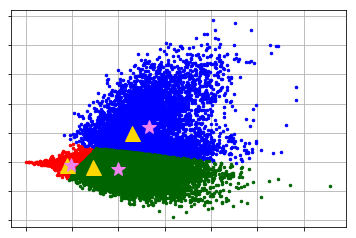

In [55]:
# Plot clusters
plot_k_medoids(tfidf_dtm_2_dim, starting_medoids_points, clusters, medoids)

#### Here Triangle(^) marker are user defined medoids and Star(*) markers are calculated medoids by k-medoids algorithm.

<br/>
<br/>

#### K-Medoids on Average Word2Vec

In [56]:
# Vectorize text data to numerical vector
avg_w2v_arr, w2v_words = perform_avg_word2vec(CLEANED_TEXT)

Shape of data :  (50000,)
Number of sentences present in data :  50000
Length of vocabulary :  12080


Average Word2Vec: 100%|█████████████████████████████████████████████████| 50000/50000 [00:42<00:00, 1186.68 sentence/s]



Length of vectorizer :  50000


In [57]:
# Perform dimensionality reduction.
svd = TruncatedSVD(n_components=2)
avg_w2v_arr_2_dim = svd.fit_transform(avg_w2v_arr)
avg_w2v_arr_2_dim.shape

(50000, 2)

In [58]:
# Starting points for medoids
starting_medoids_points = [2, 9, 12]

# Tolerence value for convergence
tolerence = 0.001

In [59]:
# Perform K-Medoids
k_medoids = perform_k_medoids(avg_w2v_arr_2_dim, starting_medoids_points, tolerence)

In [60]:
# Get cluster and medoids
clusters,medoids =  get_cluster_N_medoids(k_medoids)

In [61]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 17199 
Number of Reviews in Cluster 1 : 9989 
Number of Reviews in Cluster 2 : 22812 


In [62]:
# Print n reviews
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
good product great blood love aim wonder product would definit order product everyth came time manner free damag

Review 2 : 
happen say name three time michael keaten star comedi two coupl live old two stori hous come back suppli store coupl sudden get caught insid bridg start tumbl lake board catch theyv got hope small dog step board car start slide bridg lake water minut later find back home find somehow somehad light fireplac done magic find dead guy known bettlejuic way get help call name three time appear survic soon wish never call name bettlejuic troublemak one save account said name three time cant leav hous els find theirselv anoth world giant sandworm stellar comedi see michael keaton awesom play lead role bettlejuic

Review 3 : 
notori earli album camper van beethoven get present cds come cardboard singl sleev price except cheap there live album also includ lengthi booklet essay santa cruz colleg rocker lifestyl earli camper cvb fan sure thin

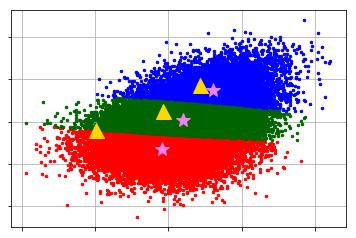

In [63]:
# Plot clusters
plot_k_medoids(avg_w2v_arr_2_dim, starting_medoids_points, clusters, medoids)

#### Here Triangle(^) marker are user defined medoids and Star(*) markers are calculated medoids by k-medoids algorithm.

<br/>
<br/>

#### K-Medoids on TFIDF Weighted Word2Vec

In [64]:
# Vectorize text data to numerical vector
tfidf_w2v_arr,w2v_words = perform_tf_idf_word2vec(CLEANED_TEXT)

Length of vocabulary :  12080


TF-IDF Weighted Word2Vec: 100%|█████████████████████████████████████████| 50000/50000 [00:12<00:00, 3909.18 sentence/s]



Length of vectorizer :  50000


In [65]:
# Perform dimensionality reduction.
svd = TruncatedSVD(n_components=2)
tfidf_w2v_arr_2_dim = svd.fit_transform(tfidf_w2v_arr)
tfidf_w2v_arr_2_dim.shape

(50000, 2)

In [66]:
# Starting points for medoids
starting_medoids_points = [2, 9, 12]

# Tolerence value for convergence
tolerence = 0.001

In [67]:
# Perform K-Medoids
k_medoids = perform_k_medoids(tfidf_w2v_arr_2_dim, starting_medoids_points, tolerence)

In [68]:
# Get cluster and medoids
clusters,medoids =  get_cluster_N_medoids(k_medoids)

In [69]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 23688 
Number of Reviews in Cluster 1 : 7220 
Number of Reviews in Cluster 2 : 19092 


In [70]:
# Print n reviews
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
sit shelf sever year thought could use blender grind still cours smoothi tast bad would realli need food processor run sever hour real cocoa melang grind thought could chew waxi bitter eat raw still sit shelf

Review 2 : 
twist rumplestiskin captur film star michael keaton geena davi prime tim burton masterpiec rumbl absurd wonder pace point dull moment

Review 3 : 
happen say name three time michael keaten star comedi two coupl live old two stori hous come back suppli store coupl sudden get caught insid bridg start tumbl lake board catch theyv got hope small dog step board car start slide bridg lake water minut later find back home find somehow somehad light fireplac done magic find dead guy known bettlejuic way get help call name three time appear survic soon wish never call name bettlejuic troublemak one save account said name three time cant leav hous els find theirselv anoth world giant sandworm stellar comedi see michael keaton awesom play lead rol

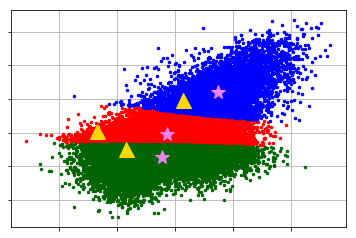

In [71]:
# Plot clusters
plot_k_medoids(tfidf_w2v_arr_2_dim, starting_medoids_points, clusters, medoids)

#### Here Triangle(^) marker are user defined medoids and Star(*) markers are calculated medoids by k-medoids algorithm.

<br/>
<br/>

### .................................... :  Agglomerative Clustering  : ....................................  

#### Note: Due to high time complexity, took only ~5000 reviews. 

In [10]:
# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset(do_not_sample = False, sample_count = 5000)


# Make CleanedText as a dataset for clustering
CLEANED_TEXT = reviews_df['CleanedText'].values

print("Dataset Shape : \n",CLEANED_TEXT.shape)

Dataset Shape : 
 (5000,)


In [11]:
# Visualize the clustering
def plot_clusters(clustering_algo,data_matrix,label_color_map,title):
    print()
    svd = TruncatedSVD(n_components=2)
    data_matrix_2_dim = svd.fit_transform(data_matrix) 

    # Compute cluster centers and predict cluster indices
    cluster_labels = clustering_algo.fit_predict(data_matrix_2_dim)

    # Define our own color map    
    label_color = [label_color_map[l] for l in cluster_labels]
    
    # Plot the scatter digram
    plt.figure(figsize = (8,6))
    for index in range(0,len(label_color)) :
        label_name = list(label_color_map.keys())[list(label_color_map.values()).index(label_color[index])]        
        plt.scatter(data_matrix_2_dim[index,0],data_matrix_2_dim[index,1], c= label_color[index],label=label_name, alpha=0.8) 
    plt.xlabel("Component 1")
    plt.ylabel("Component 2") 
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles)) 
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.show()

<br/>

#### Agglomerative Clustering on BoW

In [12]:
# Vectorize text data to numerical vector
bow_dtm,bow_count_vectorizer = perform_bow(CLEANED_TEXT)

# Sparse to dense conversion
dense_bow_dtm = bow_dtm.toarray()


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of data matrix  (5000, 9993)
The number of unique words in matrix  9993


#### With 2 Clusters : BoW

In [13]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=2,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [14]:
# Fit the model
model = agglomerativeClustering.fit(dense_bow_dtm)

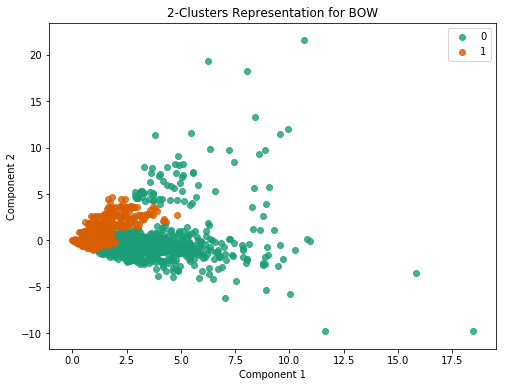

In [15]:
# Color map
cluster_colors = {0: '#1b9e77', 1: '#d95f02'} 

# Plot clustering
plot_clusters(model, dense_bow_dtm, cluster_colors,"2-Clusters Representation for BOW")

In [16]:
cluster0 = []
cluster1 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    else :
        cluster1.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))

Cluster 0 : Number of Reviews 1380
Cluster 1 : Number of Reviews 3620


Cluster 0 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




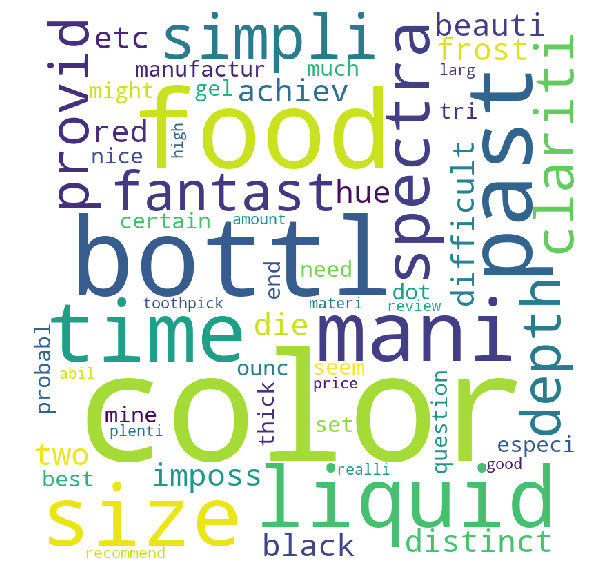



Review 2 : took air right bottl fast believ done hear click know pump enough time use bought give away wine lover friend edit dec use product say keep air week also like compani made item air idea like marinat air tight contain keep mind purchas differnt type top one work wine saver also come anoth top could top believ wine saver may older model




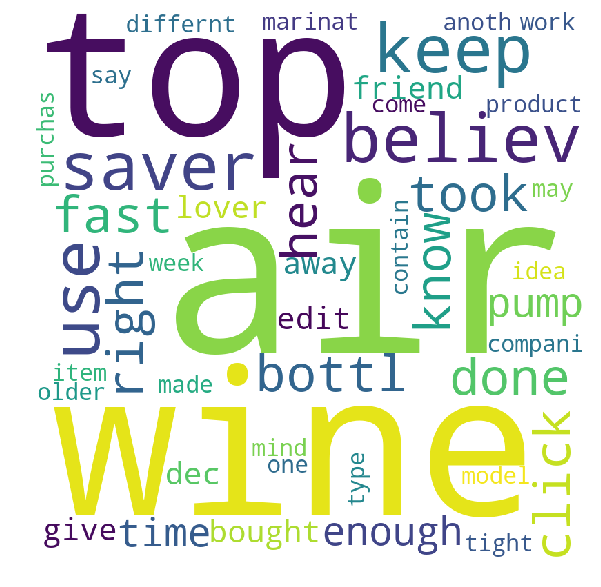

In [17]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))    
    # Plot word cloud of review 
    plot_word_cloud(review)
    print()
    print()    
    count +=1

Cluster 1 : 

Review 1 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




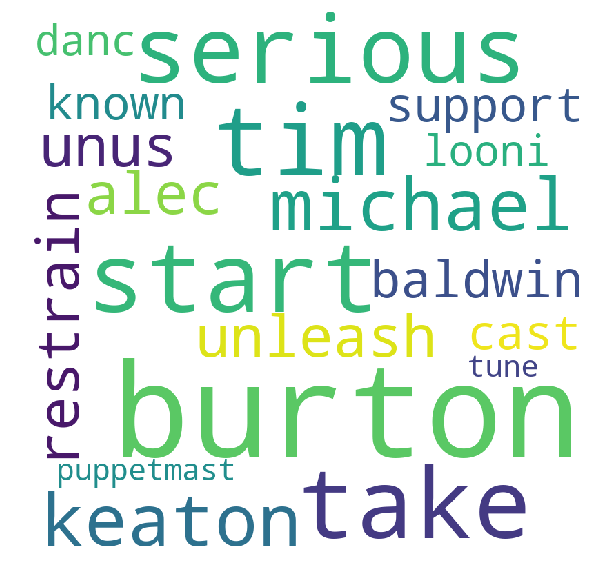



Review 2 : pierr robert similar brie smoother creamier tast best way enjoy toast point slice strawberri tang sweet berri accent enhanc chees salti may think price littl high assur youll satisfi wheel pierr robert parti tabl enjoy drown decad




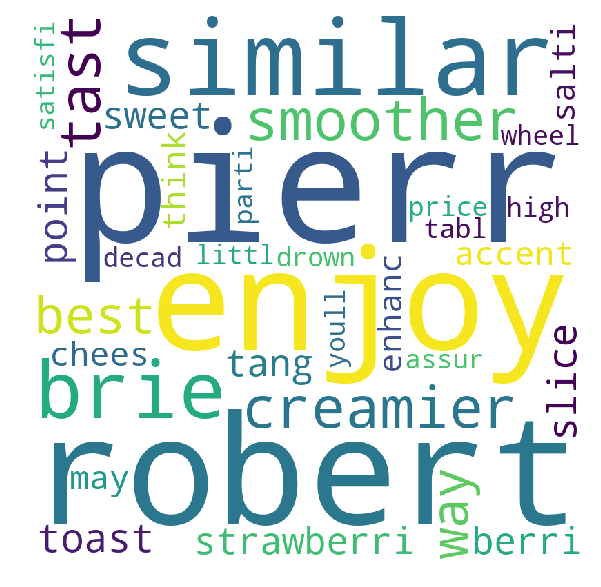

In [18]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print()
    print()  
    count +=1

#### With 5 Clusters : BoW

In [19]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=5,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [20]:
# Fit the model
model = agglomerativeClustering.fit(dense_bow_dtm)

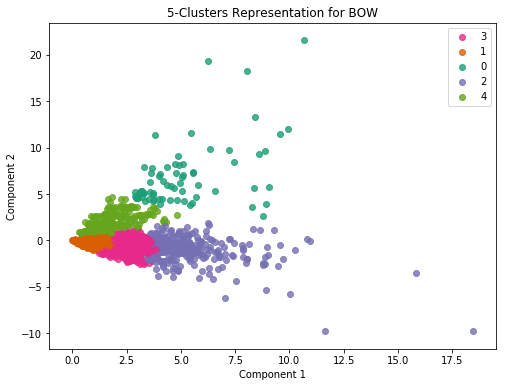

In [24]:
# Color map
cluster_colors = {0: '#1b9e77',1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'} 

# Plot clustering
plot_clusters(model, dense_bow_dtm, cluster_colors,"5-Clusters Representation for BOW")

In [30]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    else :
        cluster4.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))

Cluster 0 : Number of Reviews 70
Cluster 1 : Number of Reviews 3162
Cluster 2 : Number of Reviews 312
Cluster 3 : Number of Reviews 1134
Cluster 4 : Number of Reviews 322


Cluster 0 : 

Review 1 : organ sucanat mani level regular white granul sugar sugar take bake tea drink new level pleasur hold sugar palm hand notic irregular crystal dark brown sugar color flavor reminisc brown sugar yet textur much natur crystal take longer melt tongu recent ive discov varieti natur sweeten perfect tea add add caramel flavor tea use milk puriti flavor feel better support organ farm keep bodi healthi replac refin white brown sugar sucanat made certifi organ sugar cane sugar cane green cut mean field burn leav top cane plant left field sugar minim process sugar cane harvest press squeez cane juic juic clarifi filter evapor help remov excess water syrup crystal sugar molass flavor produc also vitamin miner trace element sugar cane plant one teaspoon sucanat contain potassium calcium still use white sugar tri sucanat might surpris ad flavor good puriti find flavor superior refin white sugar sugar add touch caramel flavor bake look even deeper flavor chocol recip tri musco

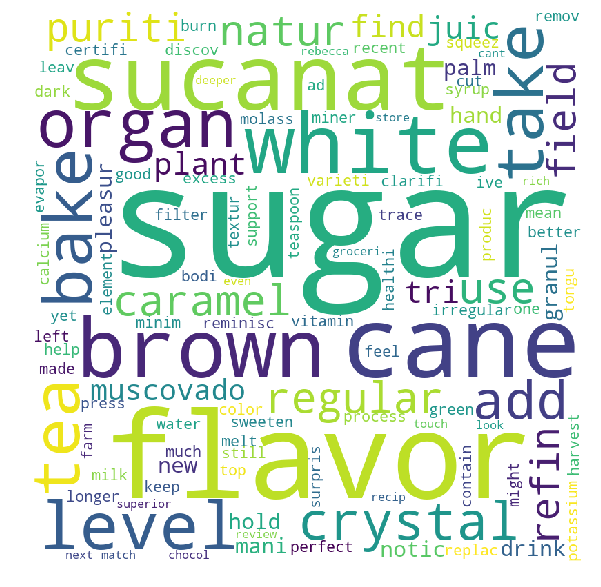



Review 2 : love tea ahmad tea perfect cup tea english tea tea choic perfect balanc never bitter matter long brew incident want purchas english tea loos form buy english afternoon tea loos pleas note howev teabag form english afternoon english tea two distinct blend loos form english afternoon english tea dont know that case that repres ahmad tea told email ask buy english tea loos form purchas loos english afteroon tea aka eng tea anoth onlin purveyor loos version tea delici mayb even bag version loos tea whole leaf tea hard find black tea usual loos black tea fine shred altogeth differ bag form loos ahmad black tea whole leaf goe show high qualiti ahmad tea terrif tea high recommend




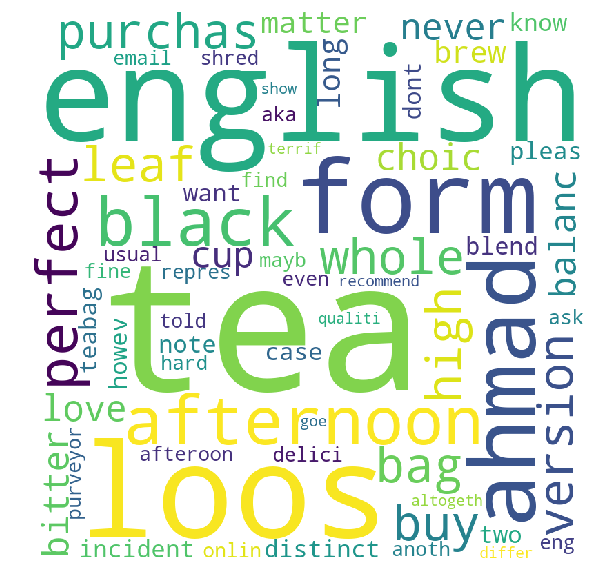

In [31]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print()
    print()  
    count +=1

Cluster 1 : 



Review 1 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




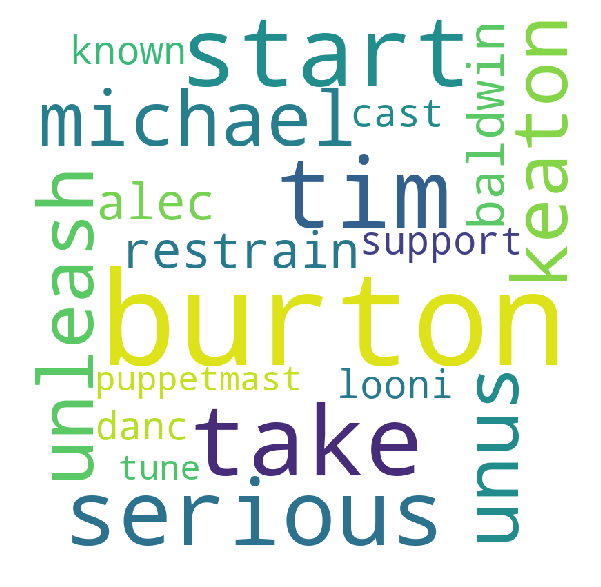



Review 2 : pierr robert similar brie smoother creamier tast best way enjoy toast point slice strawberri tang sweet berri accent enhanc chees salti may think price littl high assur youll satisfi wheel pierr robert parti tabl enjoy drown decad




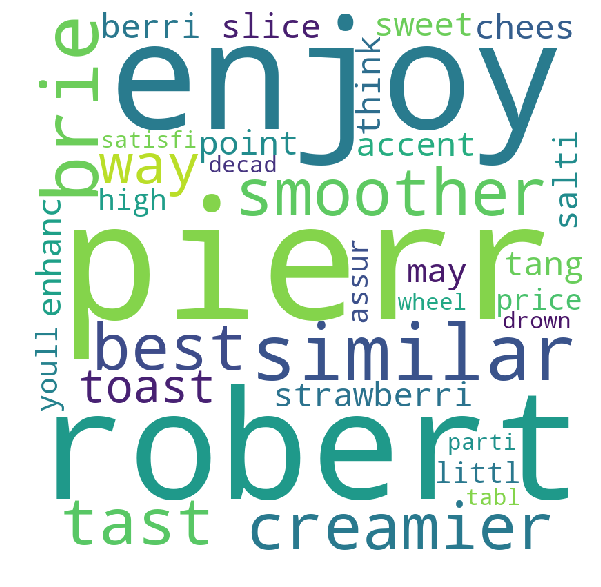

In [32]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print()
    print()
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
  
    count +=1

#### With 10 Clusters  : BoW

In [33]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=10,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [34]:
# Fit the model
model = agglomerativeClustering.fit(dense_bow_dtm)

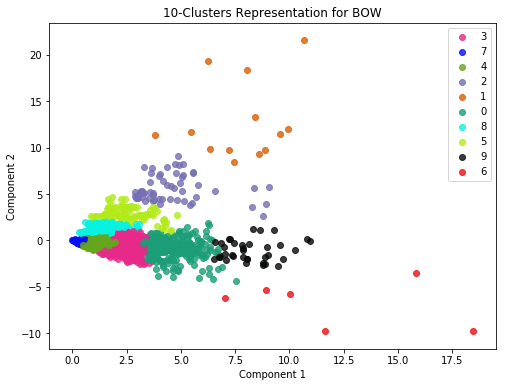

In [35]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#B2EB19',
                  6: '#EC1215',
                  7: '#080FF2',
                  8: '#08F2E0',
                  9: '#080909'} 

# Plot clustering
plot_clusters(model, dense_bow_dtm, cluster_colors,"10-Clusters Representation for BOW")

In [37]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    elif label_arr[i] == 4 :
        cluster4.append(CLEANED_TEXT[i])
    elif label_arr[i] == 5:
        cluster5.append(CLEANED_TEXT[i])
    elif label_arr[i] == 6:
        cluster6.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 7:
        cluster7.append(CLEANED_TEXT[i])
    elif label_arr[i] == 8:
        cluster8.append(CLEANED_TEXT[i])
    else :
        cluster9.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))
print("Cluster {0} : Number of Reviews {1}".format(5,len(cluster5)))
print("Cluster {0} : Number of Reviews {1}".format(6,len(cluster6)))
print("Cluster {0} : Number of Reviews {1}".format(7,len(cluster7)))
print("Cluster {0} : Number of Reviews {1}".format(8,len(cluster8)))
print("Cluster {0} : Number of Reviews {1}".format(9,len(cluster9)))

Cluster 0 : Number of Reviews 369
Cluster 1 : Number of Reviews 13
Cluster 2 : Number of Reviews 57
Cluster 3 : Number of Reviews 921
Cluster 4 : Number of Reviews 2282
Cluster 5 : Number of Reviews 100
Cluster 6 : Number of Reviews 6
Cluster 7 : Number of Reviews 987
Cluster 8 : Number of Reviews 228
Cluster 9 : Number of Reviews 37


Cluster 0 : 

Review 1 : coffe infinit better douw egbert coffe come senseo like coffe black cream sugar anyth els like realli tast coffe spot bad coffe right away bitter much smoother stronger douw egbert coffe also pod make ounc cup versus ounc per douw egbert pod pod individu wrap smell fresh tear open pod open douw egbert packet faint smell versus strong fresh smell packet even accid made cup coffe one pod second cup wasnt bad littl weak bad folk prefer weaker coffe would thought great tri four betterpod varieti kona french roast columbian sumatra mandhel french roast favorit due prefer darker roast coffe equal great otherwis think go throw away douw egbert pod came senseo find use also made espresso use ecopad senseo mode starbuck espresso roast quit strong true coffe hous espresso good nonetheless much easier setup old espresso machin betterpod would come espresso roast




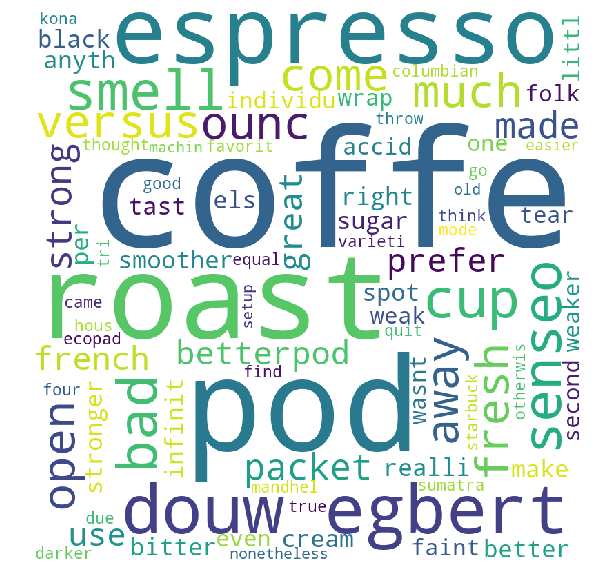






Review 2 : know lot peopl start think product fiber better product without along discount amazon com one reason purchas davinci whole wheat pasta never tri whole wheat pasta didnt know good bad cook well bit nutti flavor doesnt overwhelm spaghetti sauc kid arent readi brown pasta mix normal angel hair bewar whole wheat take longer cook prepar pasta separ also box dont know go like may want buy individu box store first




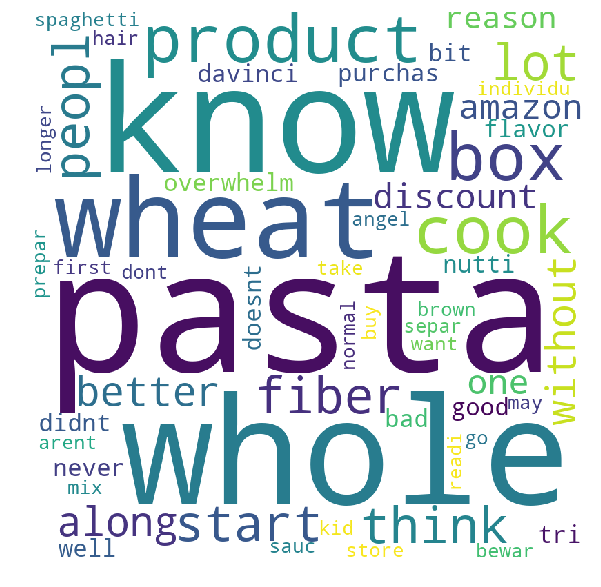

In [42]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]: 
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n\n")    
    count +=1

Cluster 1 : 

Review 1 : love tea ahmad tea perfect cup tea english tea tea choic perfect balanc never bitter matter long brew incident want purchas english tea loos form buy english afternoon tea loos pleas note howev teabag form english afternoon english tea two distinct blend loos form english afternoon english tea dont know that case that repres ahmad tea told email ask buy english tea loos form purchas loos english afteroon tea aka eng tea anoth onlin purveyor loos version tea delici mayb even bag version loos tea whole leaf tea hard find black tea usual loos black tea fine shred altogeth differ bag form loos ahmad black tea whole leaf goe show high qualiti ahmad tea terrif tea high recommend




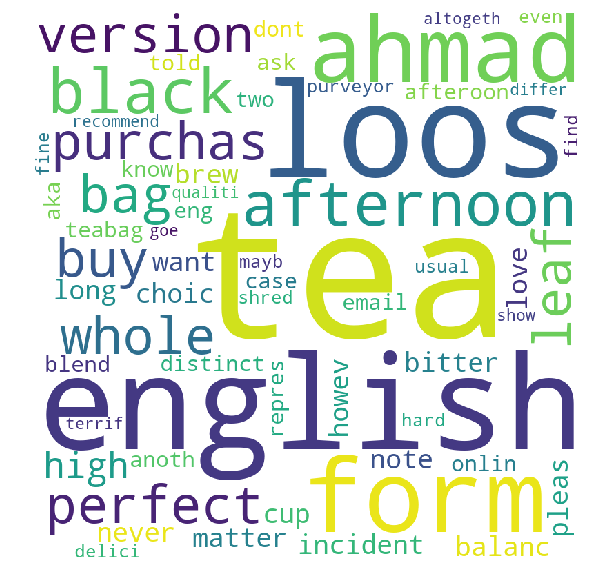





Review 2 : want subtl tea smooth sooth flavor darjeel excel choic slight floral flavor much milder earl grey especi love blend eat caramel appl cobbler clif bar reason flavor mingl nice mani tazo tea blend varieti tea tea pure blend organ black darjeel tea tea grown near india border bhutan true darjeel tea leav tea tea perfect blend organ natur sugar cane might also want tri use milk powder instead cold milk tea find help keep tea strength add creami element smooth tea darjeel satisfi blend morn tea might also enjoy awak earl grey enjoy tea love packag tazo tea individu wrap nice crink sound color sooth quit beauti tea definit aesthet awar drink tazo tea liter becom magic experi someth mysteri go tea even seem magic glint luster drink tazo tea world look beauti feel much awar life find creativ soar drink tazo tea rebecca review




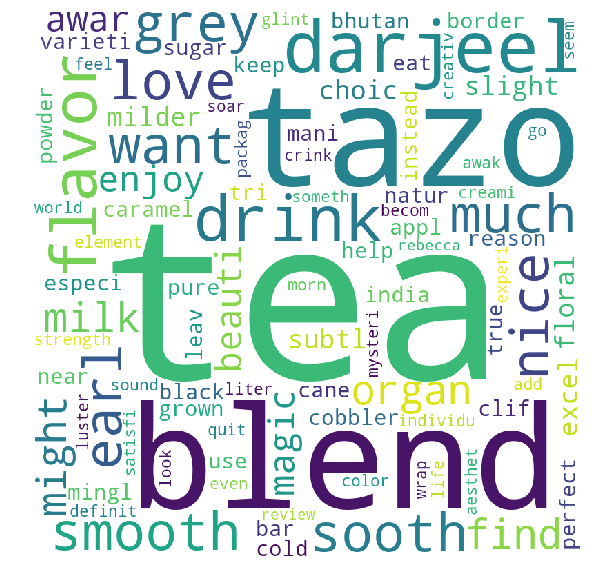

In [43]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

<br/>
<br/>

#### Agglomerative Clustering on TFIDF

In [44]:
# Vectorize text data to numerical vector
tfidf_dtm,tfidf_vectorizer = perform_tfidf(CLEANED_TEXT)

# Sparse to dense conversion
dense_tfidf_dtm = tfidf_dtm.toarray()


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (5000, 12641)
The number of unique words in train matrix  12641


#### With 2 Clusters : TFIDF

In [45]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=2,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [46]:
# Fit the model
model = agglomerativeClustering.fit(dense_tfidf_dtm)

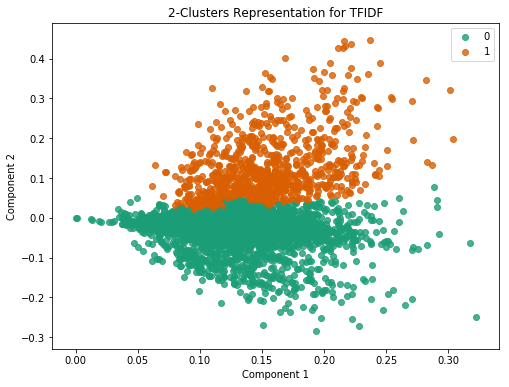

In [48]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02'} 

# Plot clustering
plot_clusters(model, dense_tfidf_dtm, cluster_colors,"2-Clusters Representation for TFIDF")

In [49]:
cluster0 = []
cluster1 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    else :
        cluster1.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))

Cluster 0 : Number of Reviews 4145
Cluster 1 : Number of Reviews 855


Cluster 0 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




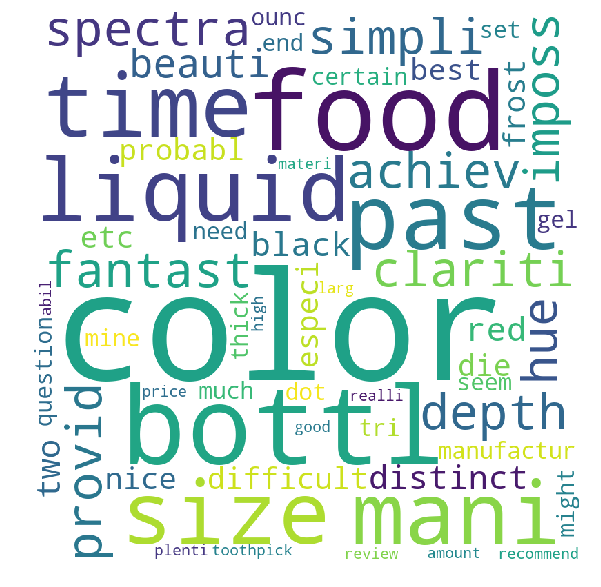





Review 2 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




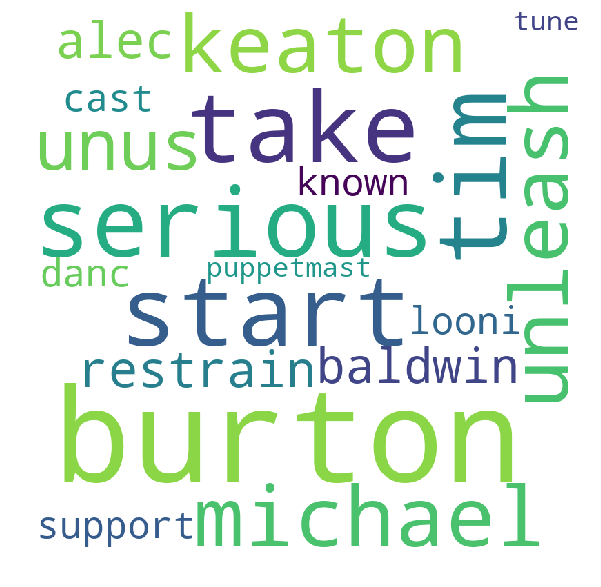

In [51]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:  
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

Cluster 1 : 

Review 1 : organ sucanat mani level regular white granul sugar sugar take bake tea drink new level pleasur hold sugar palm hand notic irregular crystal dark brown sugar color flavor reminisc brown sugar yet textur much natur crystal take longer melt tongu recent ive discov varieti natur sweeten perfect tea add add caramel flavor tea use milk puriti flavor feel better support organ farm keep bodi healthi replac refin white brown sugar sucanat made certifi organ sugar cane sugar cane green cut mean field burn leav top cane plant left field sugar minim process sugar cane harvest press squeez cane juic juic clarifi filter evapor help remov excess water syrup crystal sugar molass flavor produc also vitamin miner trace element sugar cane plant one teaspoon sucanat contain potassium calcium still use white sugar tri sucanat might surpris ad flavor good puriti find flavor superior refin white sugar sugar add touch caramel flavor bake look even deeper flavor chocol recip tri musco

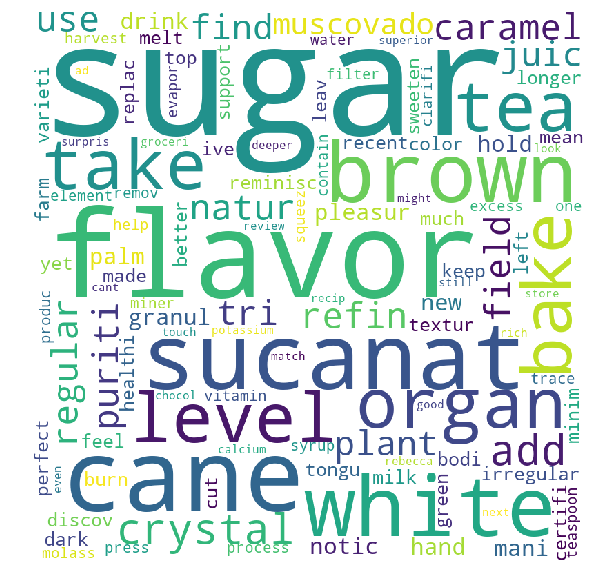





Review 2 : seduc breakfast blend coffe drink later day without fear wide eye awak night flavor remind bit hazelnut toast nut like use vanilla syrup vanilla flavor stevia sweeten coffe rebecca review




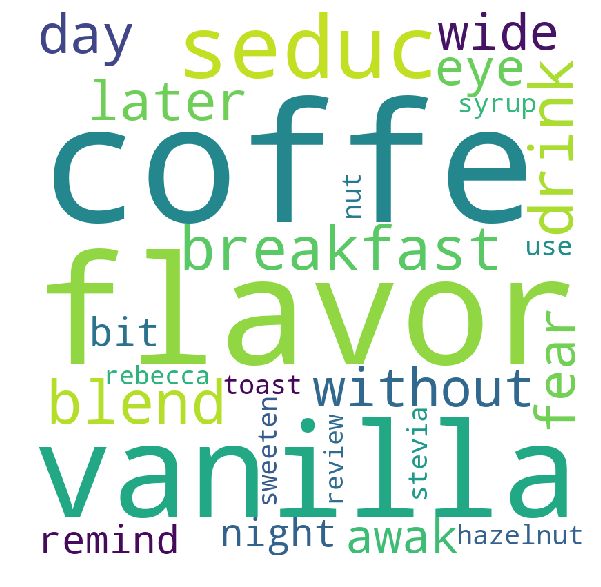

In [52]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:  
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

#### With 5 Clusters : TFIDF

In [53]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=5,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [54]:
# Fit the model
model = agglomerativeClustering.fit(dense_tfidf_dtm)

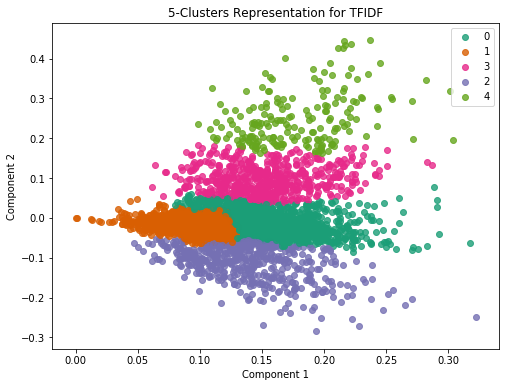

In [55]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e'
                 } 

# Plot clustering
plot_clusters(model, dense_tfidf_dtm, cluster_colors,"5-Clusters Representation for TFIDF")

In [57]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    else :
        cluster4.append(CLEANED_TEXT[i])
         
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))

Cluster 0 : Number of Reviews 1701
Cluster 1 : Number of Reviews 1993
Cluster 2 : Number of Reviews 541
Cluster 3 : Number of Reviews 570
Cluster 4 : Number of Reviews 195


Cluster 0 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




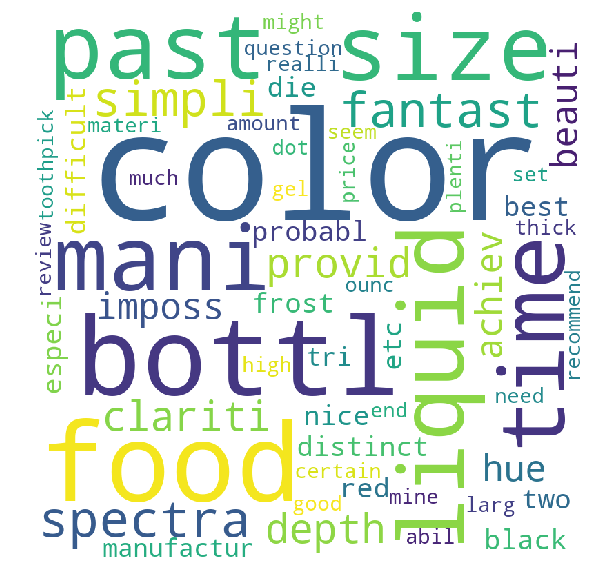





Review 2 : took air right bottl fast believ done hear click know pump enough time use bought give away wine lover friend edit dec use product say keep air week also like compani made item air idea like marinat air tight contain keep mind purchas differnt type top one work wine saver also come anoth top could top believ wine saver may older model




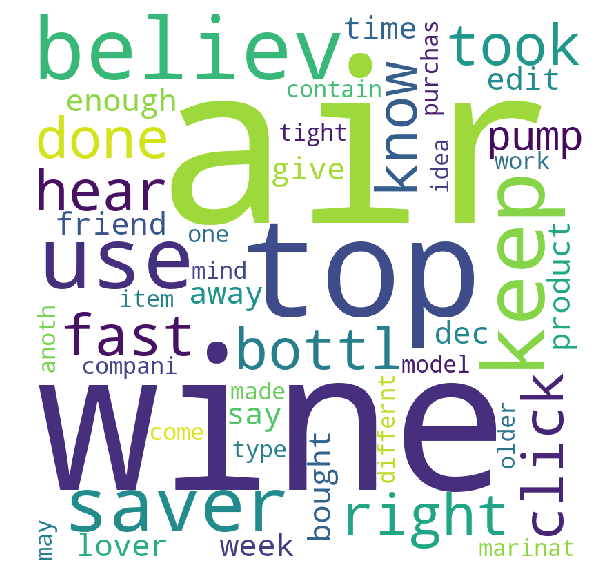

In [58]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review) 
    print("\n\n\n")  
    count +=1

Cluster 1 : 

Review 1 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




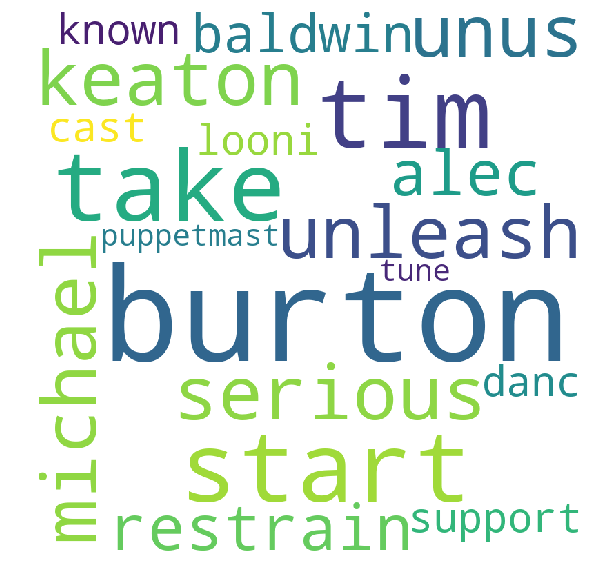





Review 2 : pierr robert similar brie smoother creamier tast best way enjoy toast point slice strawberri tang sweet berri accent enhanc chees salti may think price littl high assur youll satisfi wheel pierr robert parti tabl enjoy drown decad




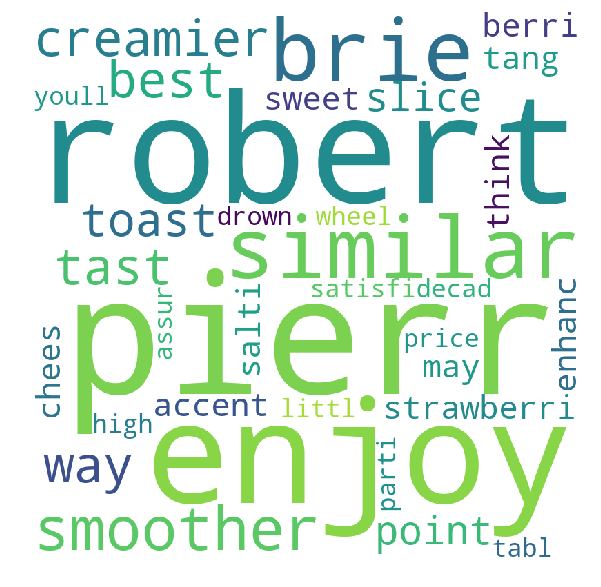

In [59]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

#### With 10 Clusters : TFIDF

In [60]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=10,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [61]:
# Fit the model
model = agglomerativeClustering.fit(dense_tfidf_dtm)

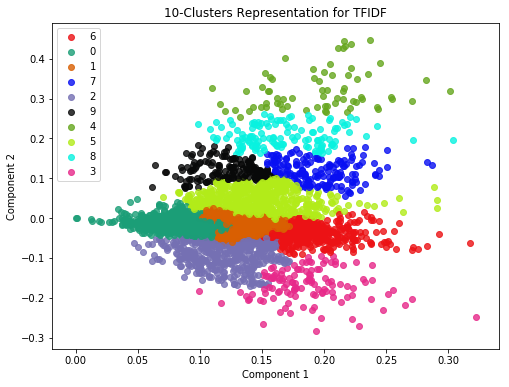

In [62]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#B2EB19',
                  6: '#EC1215',
                  7: '#080FF2',
                  8: '#08F2E0',
                  9: '#080909'} 

# Plot clustering
plot_clusters(model, dense_tfidf_dtm, cluster_colors,"10-Clusters Representation for TFIDF")

In [63]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

label_arr = model.labels_


for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    elif label_arr[i] == 4 :
        cluster4.append(CLEANED_TEXT[i])
    elif label_arr[i] == 5:
        cluster5.append(CLEANED_TEXT[i])
    elif label_arr[i] == 6:
        cluster6.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 7:
        cluster7.append(CLEANED_TEXT[i])
    elif label_arr[i] == 8:
        cluster8.append(CLEANED_TEXT[i])
    else :
        cluster9.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))
print("Cluster {0} : Number of Reviews {1}".format(5,len(cluster5)))
print("Cluster {0} : Number of Reviews {1}".format(6,len(cluster6)))
print("Cluster {0} : Number of Reviews {1}".format(7,len(cluster7)))
print("Cluster {0} : Number of Reviews {1}".format(8,len(cluster8)))
print("Cluster {0} : Number of Reviews {1}".format(9,len(cluster9)))

Cluster 0 : Number of Reviews 1454
Cluster 1 : Number of Reviews 1366
Cluster 2 : Number of Reviews 455
Cluster 3 : Number of Reviews 122
Cluster 4 : Number of Reviews 69
Cluster 5 : Number of Reviews 588
Cluster 6 : Number of Reviews 500
Cluster 7 : Number of Reviews 160
Cluster 8 : Number of Reviews 130
Cluster 9 : Number of Reviews 156


Cluster 0 : 

Review 1 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




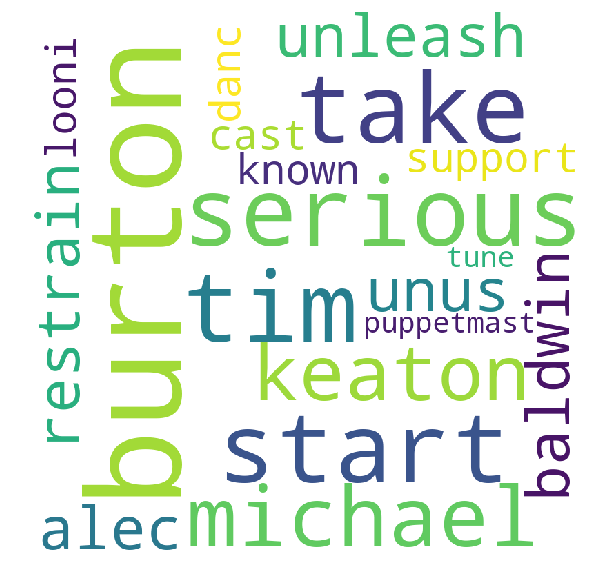





Review 2 : live exil denver couldnt surviv without bit miami best follow work everi friday morn cafe cubano




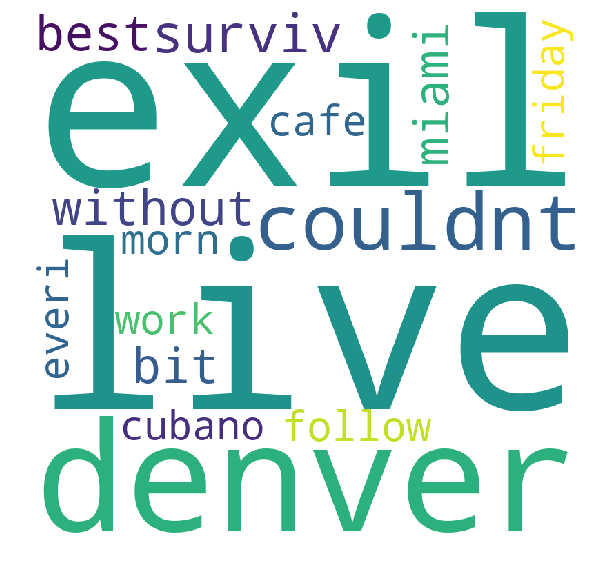

In [64]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

Cluster 1 : 

Review 1 : pierr robert similar brie smoother creamier tast best way enjoy toast point slice strawberri tang sweet berri accent enhanc chees salti may think price littl high assur youll satisfi wheel pierr robert parti tabl enjoy drown decad




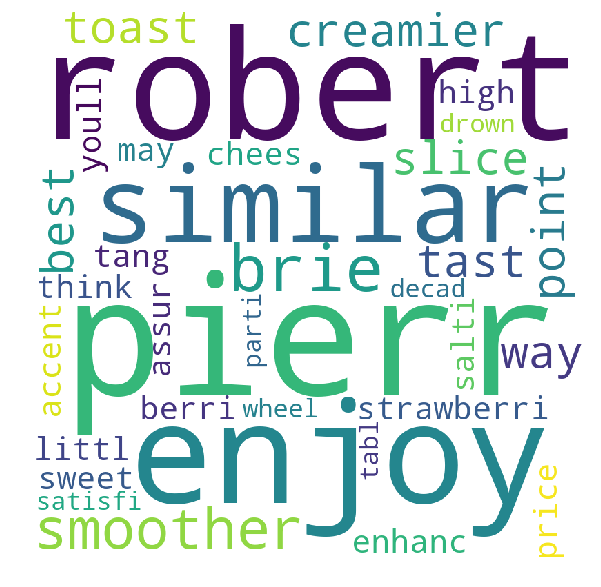





Review 2 : took air right bottl fast believ done hear click know pump enough time use bought give away wine lover friend edit dec use product say keep air week also like compani made item air idea like marinat air tight contain keep mind purchas differnt type top one work wine saver also come anoth top could top believ wine saver may older model




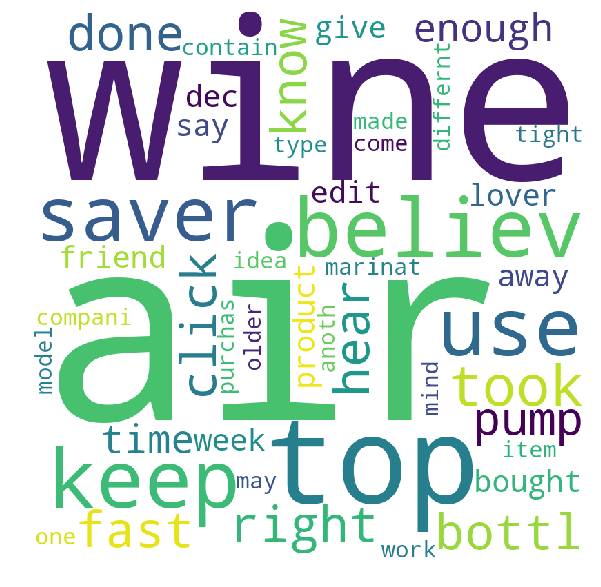

In [65]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]: 
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review) 
    print("\n\n\n")
    count +=1

<br/>
<br/>

#### Agglomerative Clustering on Average Word2Vec

In [66]:
# Vectorize text data to numerical vector
avg_word2vec,w2v_words = perform_avg_word2vec(CLEANED_TEXT)

# Convert list to numpy array
avg_word2vec_arr = np.asarray(avg_word2vec)

Shape of data :  (5000,)
Number of sentences present in data :  5000
Length of vocabulary :  4280


Average Word2Vec: 100%|███████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1630.81 sentence/s]



Length of vectorizer :  5000


#### With 2 Clusters : Average Word2Vec

In [67]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=2,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [68]:
# Fit the model
model = agglomerativeClustering.fit(avg_word2vec_arr)

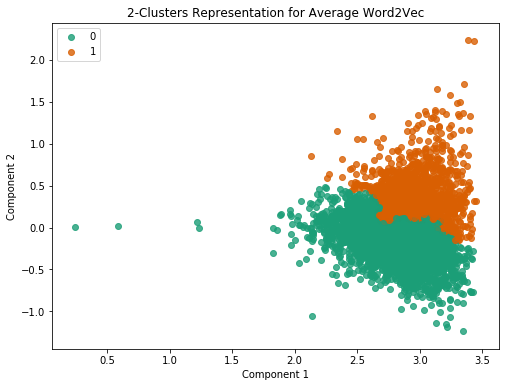

In [69]:
# Color map
cluster_colors = {0: '#1b9e77',1: '#d95f02'} 

# Plot clustering
plot_clusters(model, avg_word2vec_arr, cluster_colors,"2-Clusters Representation for Average Word2Vec")

In [71]:
cluster0 = []
cluster1 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    else :
        cluster1.append(CLEANED_TEXT[i])    
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))

Cluster 0 : Number of Reviews 3502
Cluster 1 : Number of Reviews 1498


Cluster 0 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




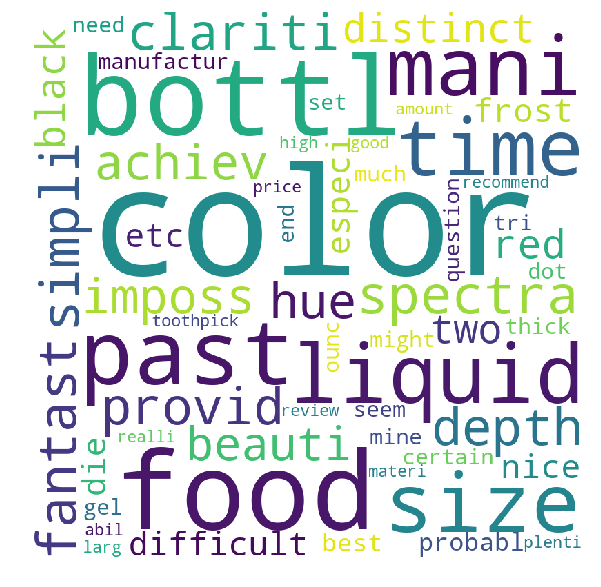





Review 2 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




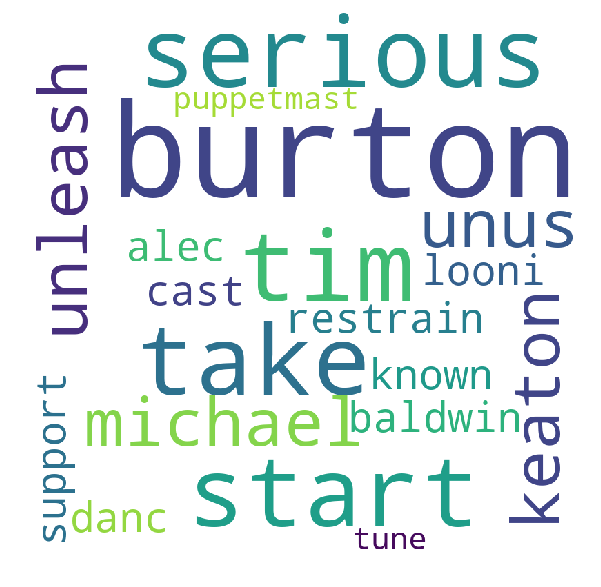

In [72]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]: 
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)  
    print("\n\n\n")  
    count +=1

Cluster 1 : 

Review 1 : took air right bottl fast believ done hear click know pump enough time use bought give away wine lover friend edit dec use product say keep air week also like compani made item air idea like marinat air tight contain keep mind purchas differnt type top one work wine saver also come anoth top could top believ wine saver may older model




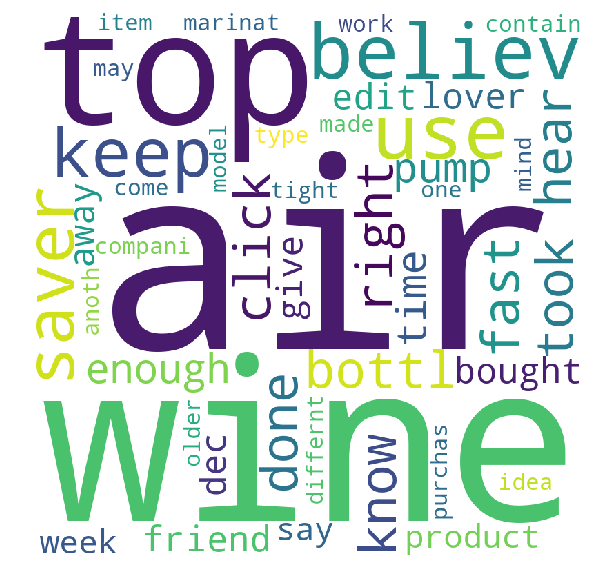





Review 2 : coffe machin probabl best coffe maker ive ever use long use coffe pod purchas mine target disast sinc dont keep consist stock recommend coffe pod coffe maker purchas pod amazon depend tax free




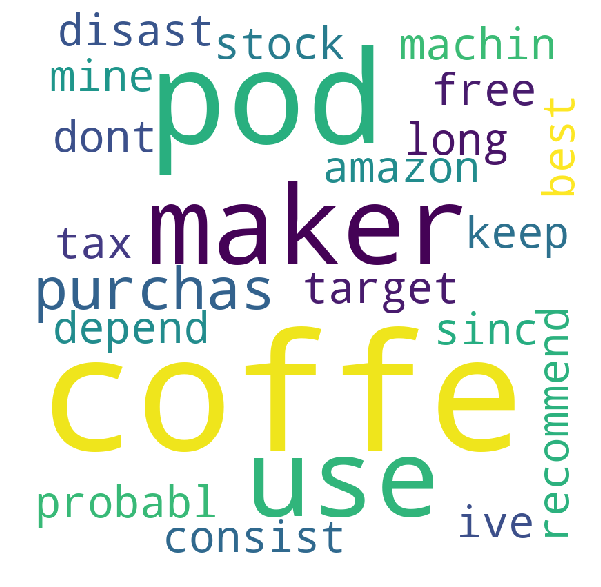

In [73]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")  
    count +=1

#### With 5 Clusters : Average Word2Vec

In [74]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=5,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [75]:
# Fit the model
model = agglomerativeClustering.fit(avg_word2vec_arr)

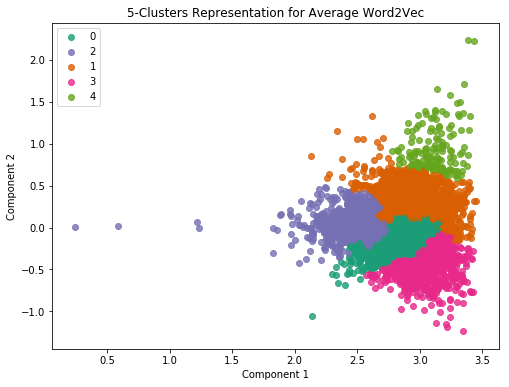

In [76]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e'} 

# Plot clustering
plot_clusters(model, avg_word2vec_arr, cluster_colors,"5-Clusters Representation for Average Word2Vec")

In [77]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    else :
        cluster4.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))

Cluster 0 : Number of Reviews 1675
Cluster 1 : Number of Reviews 1347
Cluster 2 : Number of Reviews 964
Cluster 3 : Number of Reviews 863
Cluster 4 : Number of Reviews 151


Cluster 0 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




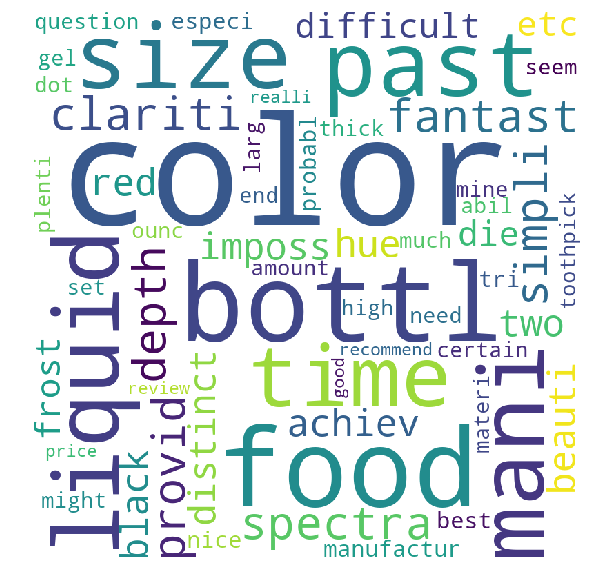





Review 2 : organ sucanat mani level regular white granul sugar sugar take bake tea drink new level pleasur hold sugar palm hand notic irregular crystal dark brown sugar color flavor reminisc brown sugar yet textur much natur crystal take longer melt tongu recent ive discov varieti natur sweeten perfect tea add add caramel flavor tea use milk puriti flavor feel better support organ farm keep bodi healthi replac refin white brown sugar sucanat made certifi organ sugar cane sugar cane green cut mean field burn leav top cane plant left field sugar minim process sugar cane harvest press squeez cane juic juic clarifi filter evapor help remov excess water syrup crystal sugar molass flavor produc also vitamin miner trace element sugar cane plant one teaspoon sucanat contain potassium calcium still use white sugar tri sucanat might surpris ad flavor good puriti find flavor superior refin white sugar sugar add touch caramel flavor bake look even deeper flavor chocol recip tri muscovado sugar

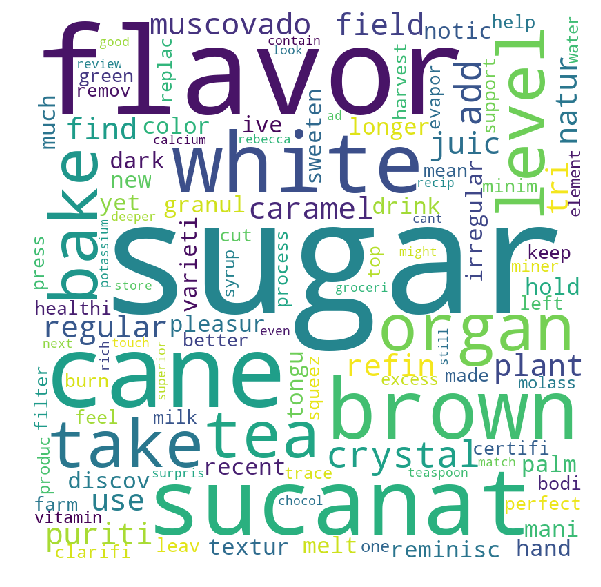

In [78]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

Cluster 1 : 

Review 1 : took air right bottl fast believ done hear click know pump enough time use bought give away wine lover friend edit dec use product say keep air week also like compani made item air idea like marinat air tight contain keep mind purchas differnt type top one work wine saver also come anoth top could top believ wine saver may older model




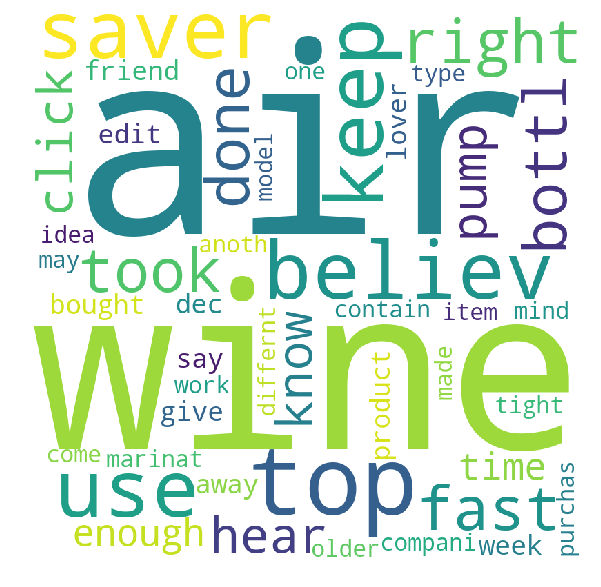





Review 2 : coffe machin probabl best coffe maker ive ever use long use coffe pod purchas mine target disast sinc dont keep consist stock recommend coffe pod coffe maker purchas pod amazon depend tax free




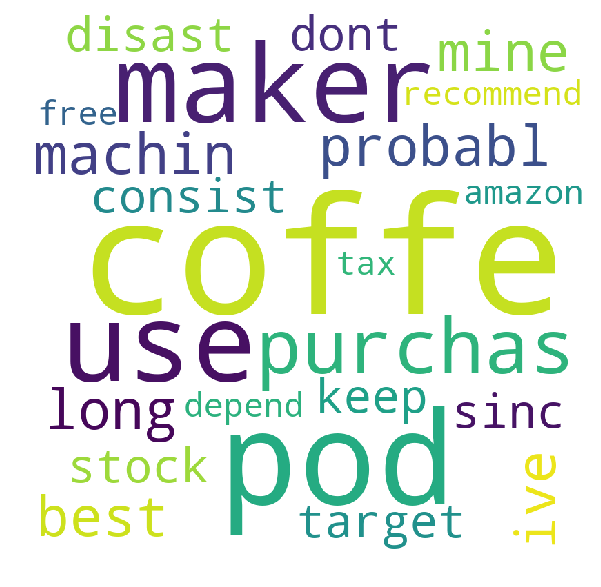

In [79]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]: 
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

#### With 10 Clusters : Average Word2Vec

In [80]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=10,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [81]:
# Fit the model
model = agglomerativeClustering.fit(avg_word2vec_arr)

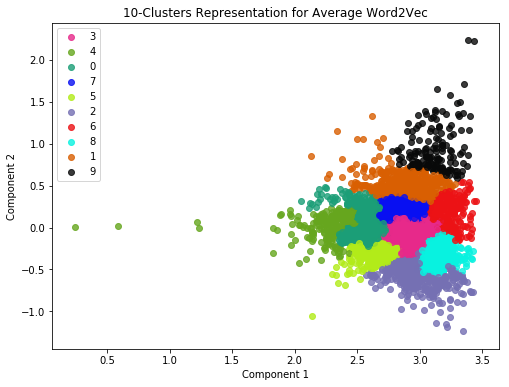

In [82]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#B2EB19',
                  6: '#EC1215',
                  7: '#080FF2',
                  8: '#08F2E0',
                  9: '#080909'} 

# Plot clustering
plot_clusters(model, avg_word2vec_arr, cluster_colors,"10-Clusters Representation for Average Word2Vec")

In [83]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    elif label_arr[i] == 4 :
        cluster4.append(CLEANED_TEXT[i])
    elif label_arr[i] == 5:
        cluster5.append(CLEANED_TEXT[i])
    elif label_arr[i] == 6:
        cluster6.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 7:
        cluster7.append(CLEANED_TEXT[i])
    elif label_arr[i] == 8:
        cluster8.append(CLEANED_TEXT[i])
    else :
        cluster9.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))
print("Cluster {0} : Number of Reviews {1}".format(5,len(cluster5)))
print("Cluster {0} : Number of Reviews {1}".format(6,len(cluster6)))
print("Cluster {0} : Number of Reviews {1}".format(7,len(cluster7)))
print("Cluster {0} : Number of Reviews {1}".format(8,len(cluster8)))
print("Cluster {0} : Number of Reviews {1}".format(9,len(cluster9)))

Cluster 0 : Number of Reviews 730
Cluster 1 : Number of Reviews 453
Cluster 2 : Number of Reviews 442
Cluster 3 : Number of Reviews 1239
Cluster 4 : Number of Reviews 234
Cluster 5 : Number of Reviews 436
Cluster 6 : Number of Reviews 250
Cluster 7 : Number of Reviews 644
Cluster 8 : Number of Reviews 421
Cluster 9 : Number of Reviews 151


Cluster 0 : 

Review 1 : live exil denver couldnt surviv without bit miami best follow work everi friday morn cafe cubano




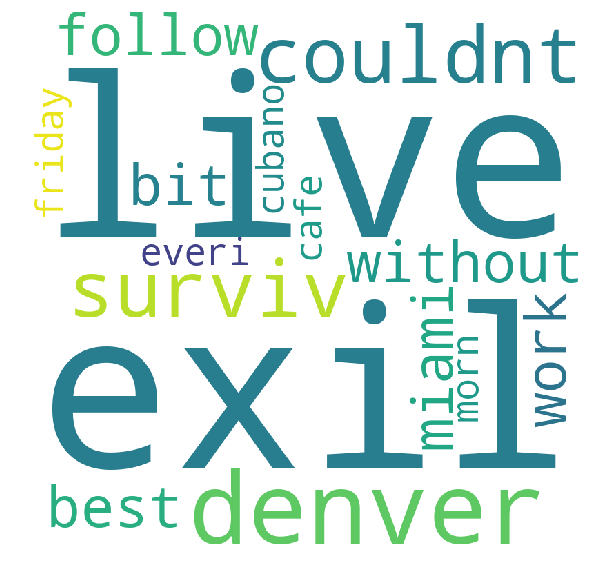





Review 2 : agre guy complain consist wast two expens pod far first time use kona pod machin jam could open hour caus steam lock tablespoon undrink crap came senseo next time tri kona pod got quarter amount two cup tri impress far afraid tri




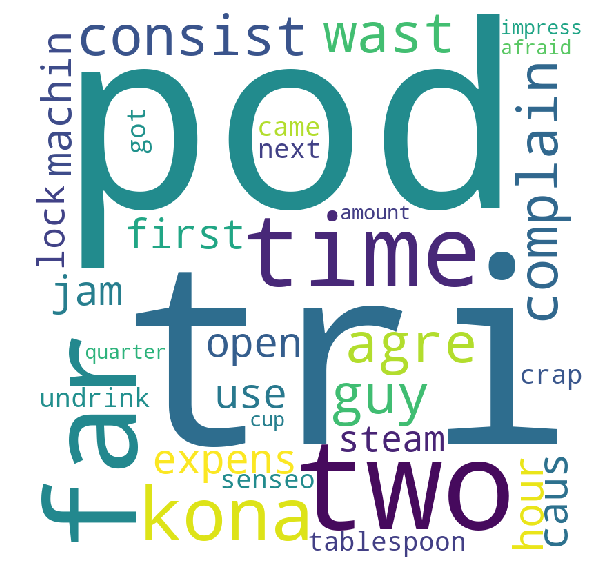

In [84]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]: 
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

Cluster 1 : 

Review 1 : rather dissapoint product ive lavazza rememb flavor mild may old stock best use date bag month ago wont order amazon fear somebodi get rid old stock mail order ill find reput store




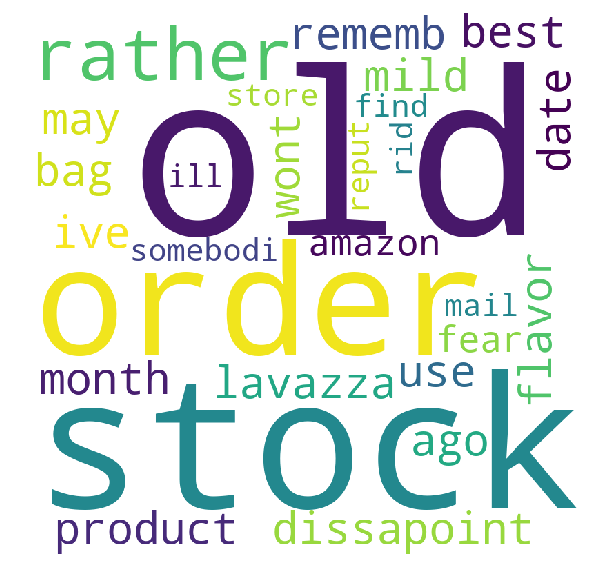





Review 2 : use spike popcorn veggi meat soup egg name healthier season delici elat know order onlin health food store alway easi get




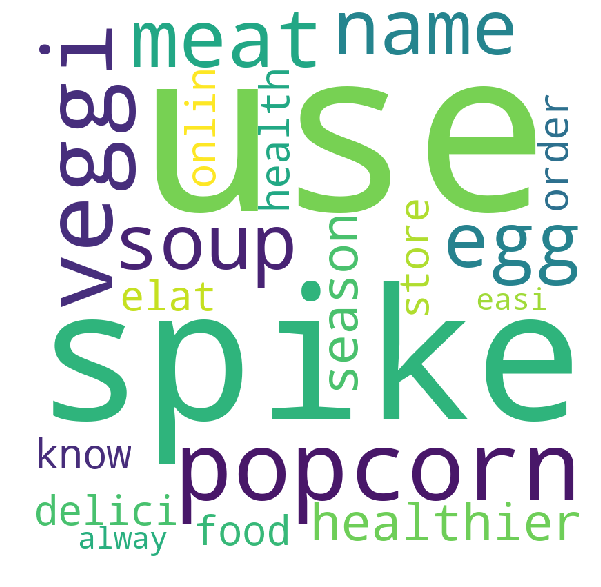

In [85]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

<br/>
<br/>

#### Agglomerative Clustering on TFIDF Weighted Word2Vec

In [87]:
# Vectorize text data to numerical vector
tf_idf_word2vec,w2v_words = perform_tf_idf_word2vec(CLEANED_TEXT)

# Sparse to dense conversion
tf_idf_word2vec_arr = np.asarray(tf_idf_word2vec)

Length of vocabulary :  4280


TF-IDF Weighted Word2Vec: 100%|███████████████████████████████████████████| 5000/5000 [00:01<00:00, 3783.68 sentence/s]



Length of vectorizer :  5000


#### With 2 Clusters : TFIDF Weighted Word2Vec

In [88]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=2,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [89]:
# Fit the model
model = agglomerativeClustering.fit(tf_idf_word2vec_arr)

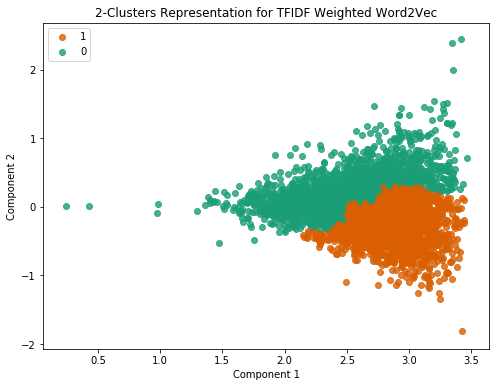

In [90]:
# Color map
cluster_colors = {0: '#1b9e77',1: '#d95f02'} 

# Plot clustering
plot_clusters(model, tf_idf_word2vec_arr, cluster_colors,"2-Clusters Representation for TFIDF Weighted Word2Vec")

In [91]:
cluster0 = []
cluster1 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    else :
        cluster1.append(CLEANED_TEXT[i])   
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))

Cluster 0 : Number of Reviews 2279
Cluster 1 : Number of Reviews 2721


Cluster 0 : 

Review 1 : tim burton start take serious michael keaton unleash unus restrain alec baldwin support cast known looni danc puppetmast burton tune




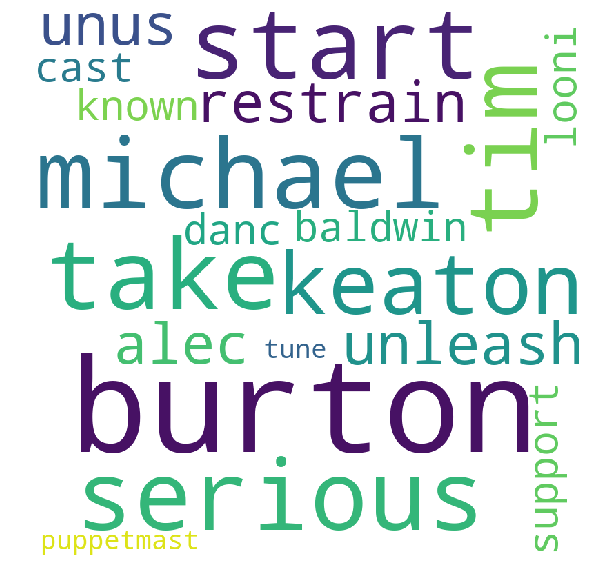





Review 2 : pierr robert similar brie smoother creamier tast best way enjoy toast point slice strawberri tang sweet berri accent enhanc chees salti may think price littl high assur youll satisfi wheel pierr robert parti tabl enjoy drown decad




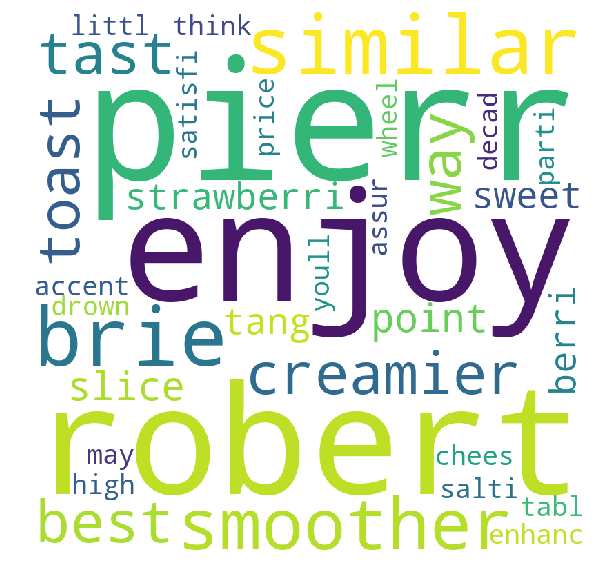

In [92]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

Cluster 1 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




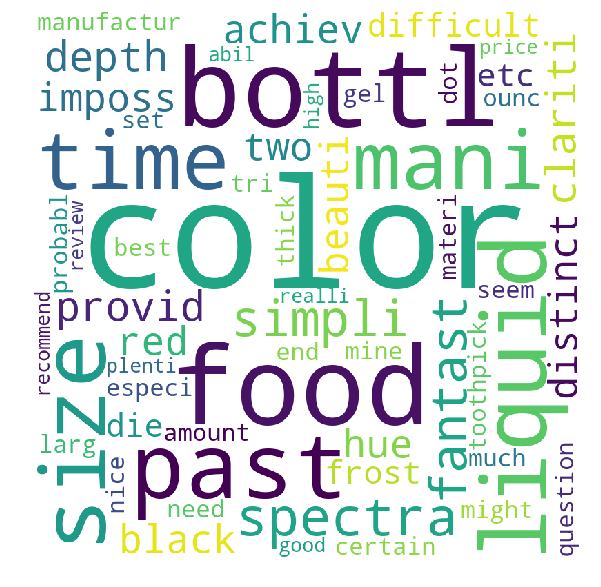





Review 2 : organ sucanat mani level regular white granul sugar sugar take bake tea drink new level pleasur hold sugar palm hand notic irregular crystal dark brown sugar color flavor reminisc brown sugar yet textur much natur crystal take longer melt tongu recent ive discov varieti natur sweeten perfect tea add add caramel flavor tea use milk puriti flavor feel better support organ farm keep bodi healthi replac refin white brown sugar sucanat made certifi organ sugar cane sugar cane green cut mean field burn leav top cane plant left field sugar minim process sugar cane harvest press squeez cane juic juic clarifi filter evapor help remov excess water syrup crystal sugar molass flavor produc also vitamin miner trace element sugar cane plant one teaspoon sucanat contain potassium calcium still use white sugar tri sucanat might surpris ad flavor good puriti find flavor superior refin white sugar sugar add touch caramel flavor bake look even deeper flavor chocol recip tri muscovado sugar

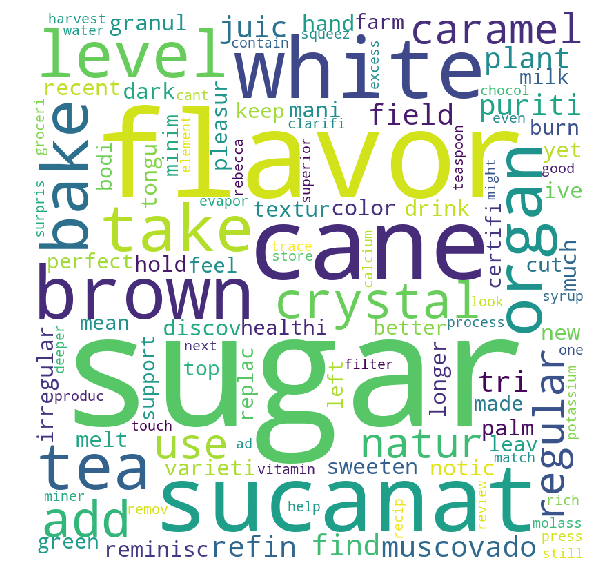

In [93]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")  
    count +=1

#### With 5 Clusters : TFIDF Weighted Word2Vec

In [94]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=5,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [95]:
# Fit the model
model = agglomerativeClustering.fit(tf_idf_word2vec_arr)

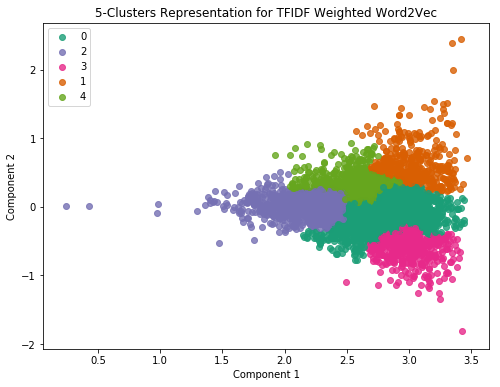

In [96]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e'} 

# Plot clustering
plot_clusters(model, tf_idf_word2vec_arr, cluster_colors,"5-Clusters Representation for TFIDF Weighted Word2Vec")

In [97]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    else :
        cluster4.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))

Cluster 0 : Number of Reviews 2234
Cluster 1 : Number of Reviews 398
Cluster 2 : Number of Reviews 1040
Cluster 3 : Number of Reviews 487
Cluster 4 : Number of Reviews 841


Cluster 0 : 

Review 1 : spectra past food color simpli fantast provid depth clariti color imposs achiev liquid food color hue beauti distinct black red two color difficult get die frost etc especi nice probabl best manufactur tri question certain size set mine bottl ounc might seem like much need dot thick gel past end toothpick color larg amount materi plenti color abil bottl mani mani time size liquid food color bottl high recommend realli good price time review




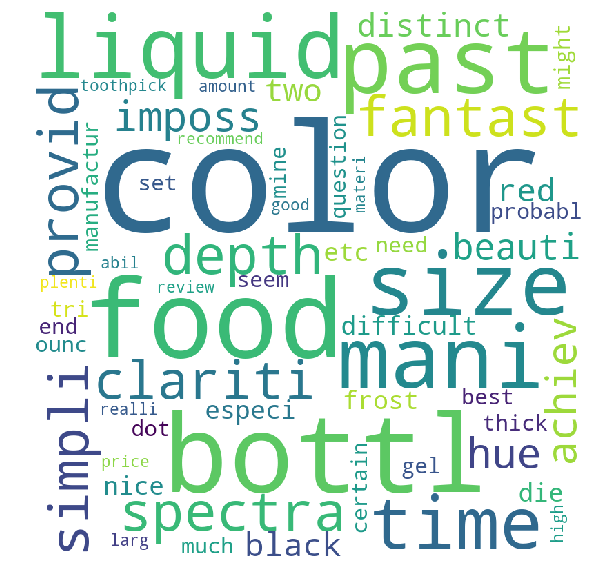

Review 2 : cat ive realli like varieti prefer slice version ground buy ground like one smell pretti normal stinki make faint seem appeal cat food get pretti posit result varieti lot pur




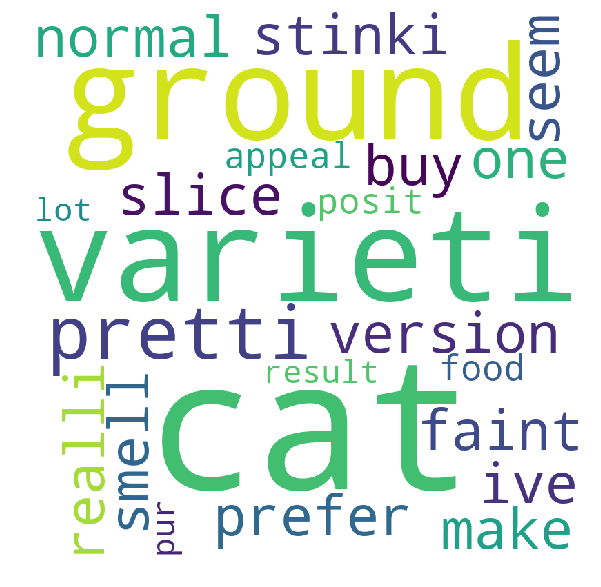

In [98]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    count +=1

Cluster 1 : 

Review 1 : yorkshi year old cant fool chew eat one bag vet pleas neptun teeth sinc chew year tri may save teeth littl friend kathi




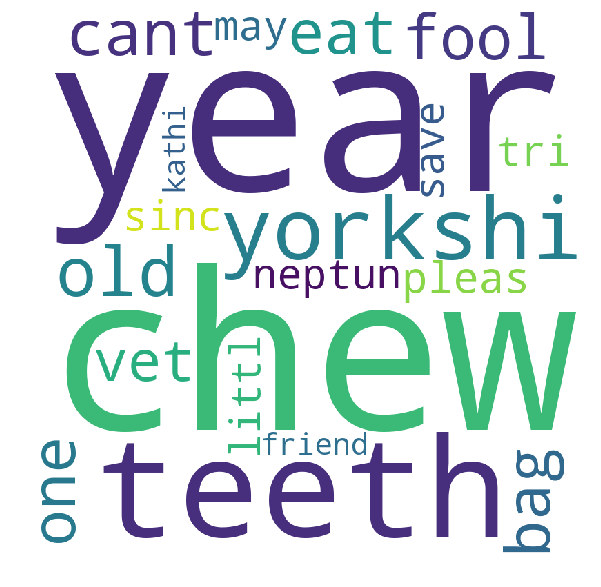





Review 2 : buy local store great product




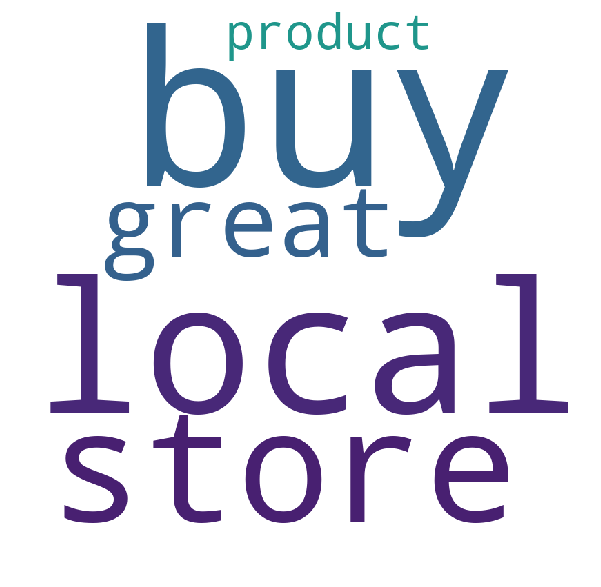

In [100]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n")
    count +=1

#### With 10 Clusters : TFIDF Weighted Word2Vec

In [101]:
agglomerativeClustering = AgglomerativeClustering(n_clusters=10,
                                                  affinity='euclidean',
                                                  compute_full_tree ='auto',
                                                  linkage ='ward')

agglomerativeClustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [102]:
# Fit the model
model = agglomerativeClustering.fit(tf_idf_word2vec_arr)

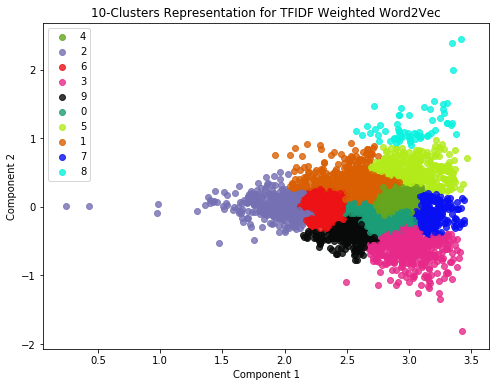

In [103]:
# Color map
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e',
                  5: '#B2EB19',
                  6: '#EC1215',
                  7: '#080FF2',
                  8: '#08F2E0',
                  9: '#080909'} 

# Plot clustering
plot_clusters(model, tf_idf_word2vec_arr, cluster_colors,"10-Clusters Representation for TFIDF Weighted Word2Vec")

In [104]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

label_arr = model.labels_

for i in range(label_arr.shape[0]):
    if label_arr[i] == 0:
        cluster0.append(CLEANED_TEXT[i])
    elif label_arr[i] == 1:
        cluster1.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 2:
        cluster2.append(CLEANED_TEXT[i])
    elif label_arr[i] == 3:
        cluster3.append(CLEANED_TEXT[i])
    elif label_arr[i] == 4 :
        cluster4.append(CLEANED_TEXT[i])
    elif label_arr[i] == 5:
        cluster5.append(CLEANED_TEXT[i])
    elif label_arr[i] == 6:
        cluster6.append(CLEANED_TEXT[i])    
    elif label_arr[i] == 7:
        cluster7.append(CLEANED_TEXT[i])
    elif label_arr[i] == 8:
        cluster8.append(CLEANED_TEXT[i])
    else :
        cluster9.append(CLEANED_TEXT[i])
 
        
# Number of reviews in each clusters
print("Cluster {0} : Number of Reviews {1}".format(0,len(cluster0)))
print("Cluster {0} : Number of Reviews {1}".format(1,len(cluster1)))
print("Cluster {0} : Number of Reviews {1}".format(2,len(cluster2)))
print("Cluster {0} : Number of Reviews {1}".format(3,len(cluster3)))
print("Cluster {0} : Number of Reviews {1}".format(4,len(cluster4)))
print("Cluster {0} : Number of Reviews {1}".format(5,len(cluster5)))
print("Cluster {0} : Number of Reviews {1}".format(6,len(cluster6)))
print("Cluster {0} : Number of Reviews {1}".format(7,len(cluster7)))
print("Cluster {0} : Number of Reviews {1}".format(8,len(cluster8)))
print("Cluster {0} : Number of Reviews {1}".format(9,len(cluster9)))

Cluster 0 : Number of Reviews 950
Cluster 1 : Number of Reviews 841
Cluster 2 : Number of Reviews 370
Cluster 3 : Number of Reviews 487
Cluster 4 : Number of Reviews 629
Cluster 5 : Number of Reviews 336
Cluster 6 : Number of Reviews 670
Cluster 7 : Number of Reviews 285
Cluster 8 : Number of Reviews 62
Cluster 9 : Number of Reviews 370


Cluster 0 : 

Review 1 : coffe machin probabl best coffe maker ive ever use long use coffe pod purchas mine target disast sinc dont keep consist stock recommend coffe pod coffe maker purchas pod amazon depend tax free




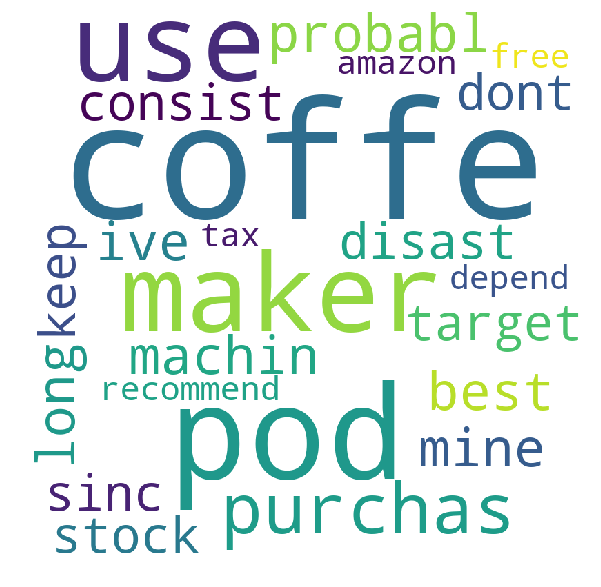





Review 2 : spent time japan shirataki noodl use bunch dish includ sukiyaki mayb that japanes thin noodl parboil remov preserv dont melt easili cook long time hard gelatin textur dont absorb flavor easili think tast better strong sauc smoke meat etc tri lower carb cut calori noodl eat




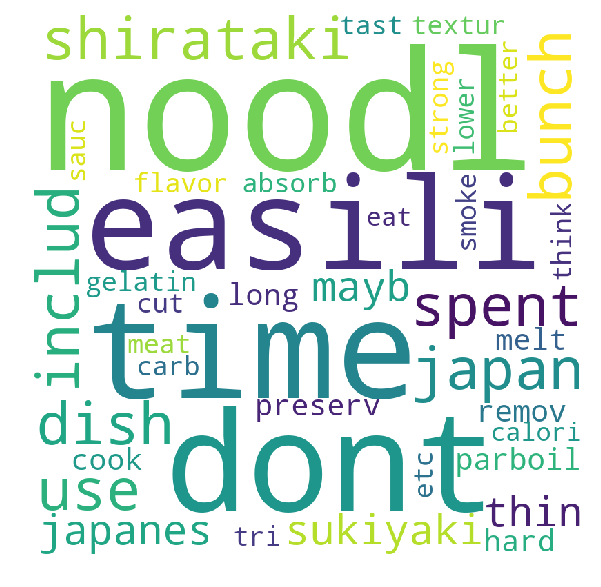

In [105]:
# Print 2 reviews from cluster 0
print("Cluster 0 : \n")
count=1
for review in cluster0[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n") 
    count +=1

Cluster 1 : 

Review 1 : fanci feast varieti pack contain can alway ensur good suppli cat food hand also wast time stack individu can alway box one slice varieti pack contain eight can beef chicken heart liver turkey also alway hand fanci feast gourmet varieti pack contain eight can ocean whitefish tuna salmon cod sole shrimp combo addit also box fanci feast grill varieti pack hand time contain eight can grill beef turkey chicken savori sauc cat mamushka love everi morn meow serv fanci feast proceed devour




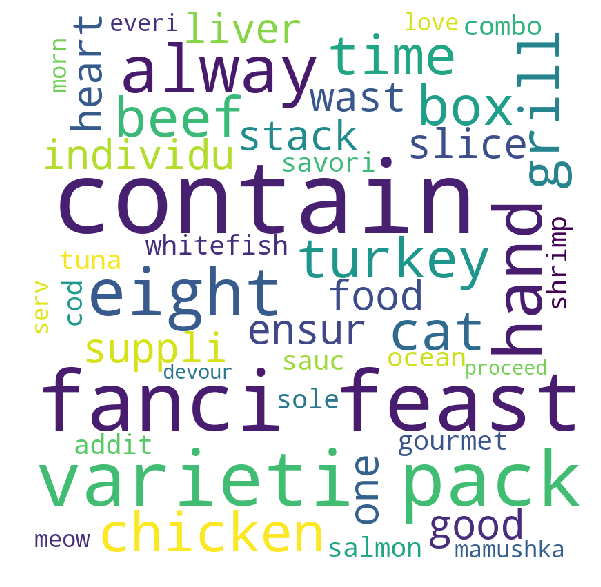





Review 2 : rather dissapoint product ive lavazza rememb flavor mild may old stock best use date bag month ago wont order amazon fear somebodi get rid old stock mail order ill find reput store




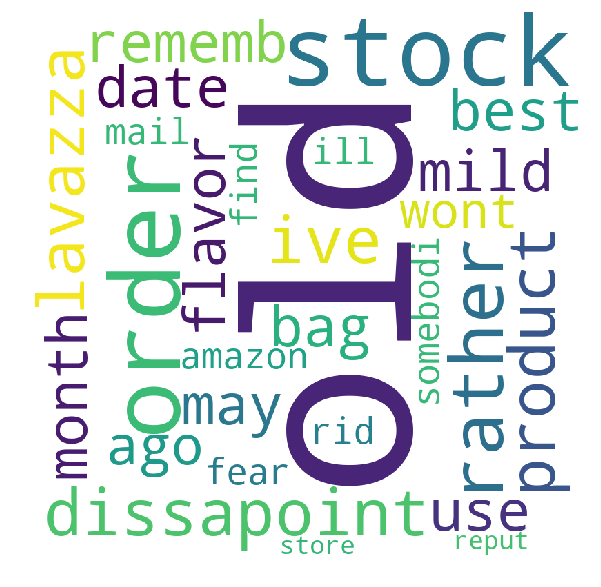

In [106]:
# Print 2 reviews from cluster 1
print("Cluster 1 : \n")
count=1
for review in cluster1[0:2]:
    print("Review {0} : {1}".format(count,review))
    # Plot word cloud of review 
    plot_word_cloud(review)
    print("\n\n\n") 
    count +=1

<br/>
<br/>

### .................................... :  Density Based Clustering (DBSCAN) : ....................................  

#### Note: Due to high dimensinality, we will perform DBSCAN on Average Word2Vec and TFIDF Weighted Word2Vec only. 
#### I tried to complete this assignment on 100k dataset, but calculating 'optimal eps' and 'dbscan.fit(avg_word2vec)' took 2 days to ran the whole thing and gave memory error at the end,that's why took 40k datapoints to complete this task.

In [8]:
# Load 'finalDataSet.sqlite' in panda's daraframe. Take around ~40K dataset.
reviews_df = load_review_dataset(do_not_sample = False,sample_count=40000)


# Make CleanedText as a dataset for clustering
CLEANED_TEXT = reviews_df['CleanedText'].values

print("Dataset Shape : \n",CLEANED_TEXT.shape)

Dataset Shape : 
 (40000,)


In [19]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
def plot_dbscan(X,labels, n_clusters, core_samples_mask):
    # Black removed and is used for noise instead.
    plt.figure(figsize=(12,8))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k',markerfacecolor=tuple(col), markersize=14,alpha=1)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k',markerfacecolor=tuple(col), markersize=6,alpha=0.5)

    plt.title('Estimated number of clusters: %d' % n_clusters)
    plt.show()


def get_distances(data , minimum_neighbour = 4):
    distance = []
    for i in tqdm(data,unit=" review",desc='Distance Calculation '):
        holder = np.sort(np.sum((data-i)**2,axis=1),axis=None)
        distance.append(holder[minimum_neighbour])
    return np.sqrt(np.array(distance)) 

    
def plot_reviews_eps(reviews,minPts=4):
    print()
    # Calculate distance of nth-nearest neighbours
    dist = get_distances(reviews,minPts)
    sorted_distance = np.sort(dist)
    points = [i for i in range(reviews.shape[0])]
    print()
    print()
    plt.plot(points, sorted_distance)
    plt.xlabel('Reiews',size=13)
    plt.ylabel('Distances ',size=13)
    plt.title('Distances vs Reviews \n',size=14)
    plt.grid()
    plt.show()
    print()

<br/>
<br/>

#### DBSCAN on Average Word2Vec

In [10]:
# Vectorize text data to numerical vector
avg_word2vec,w2v_words = perform_avg_word2vec(CLEANED_TEXT)

#Standardising the data
avg_word2vec = StandardScaler().fit_transform(avg_word2vec)

Shape of data :  (40000,)
Number of sentences present in data :  40000
Length of vocabulary :  10911


Average Word2Vec: 100%|█████████████████████████████████████████████████| 40000/40000 [00:32<00:00, 1233.56 sentence/s]



Length of vectorizer :  40000


Distance Calculation : 100%|████████████████████████████████████████████████| 40000/40000 [13:00<00:00, 51.24 review/s]


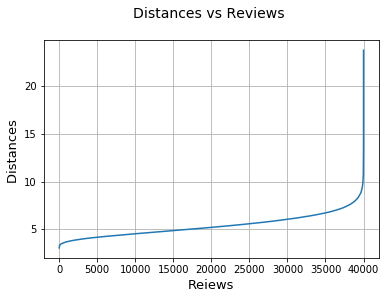

In [11]:
plot_reviews_eps(avg_word2vec,100)

<br/>

after 7, we see sudden rise in the line, so we will select 7 as an optimal eps value

<br/>

In [12]:
dbscan = DBSCAN(eps=7,min_samples = 100,n_jobs=-1)
dbscan.fit(avg_word2vec)
dbscan

DBSCAN(algorithm='auto', eps=7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

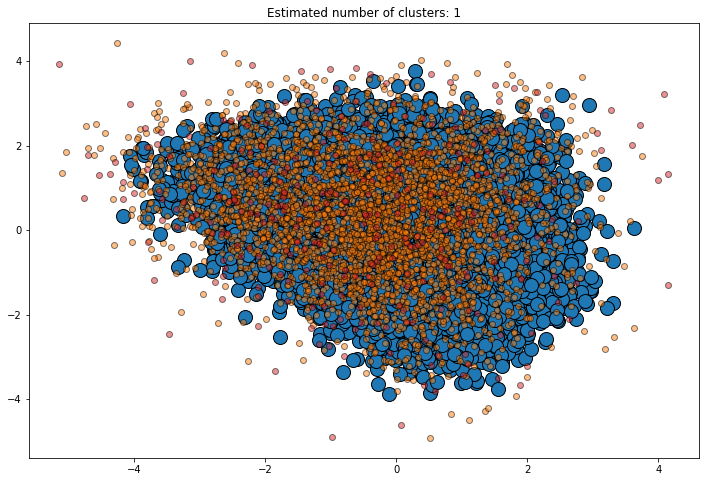

In [16]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot clustering
plot_dbscan(avg_word2vec,labels, n_clusters, core_samples_mask)

<br/>
<br/>

#### DBSCAN on TFIDF Weighted Word2Vec

In [17]:
# Vectorize text data to numerical vector
tf_idf_word2vec,w2v_words = perform_tf_idf_word2vec(CLEANED_TEXT)

#Standardising the data
tf_idf_word2vec = StandardScaler().fit_transform(tf_idf_word2vec)

Length of vocabulary :  10911


TF-IDF Weighted Word2Vec: 100%|█████████████████████████████████████████| 40000/40000 [00:11<00:00, 3620.42 sentence/s]



Length of vectorizer :  40000


Distance Calculation : 100%|████████████████████████████████████████████████| 40000/40000 [12:46<00:00, 52.18 review/s]


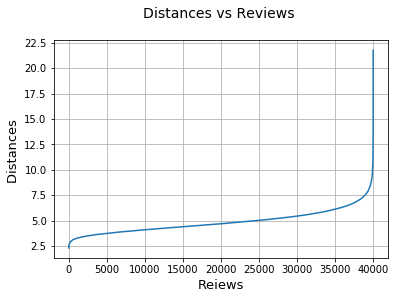

In [18]:
plot_reviews_eps(tf_idf_word2vec,100)

<br/>

after 7.5, we see sudden rise in the line, so we will select 7.5 as an optimal eps value

<br/>

In [21]:
dbscan = DBSCAN(eps=7.5,min_samples = 100,n_jobs=-1)
dbscan.fit(tf_idf_word2vec)
dbscan

DBSCAN(algorithm='auto', eps=7.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

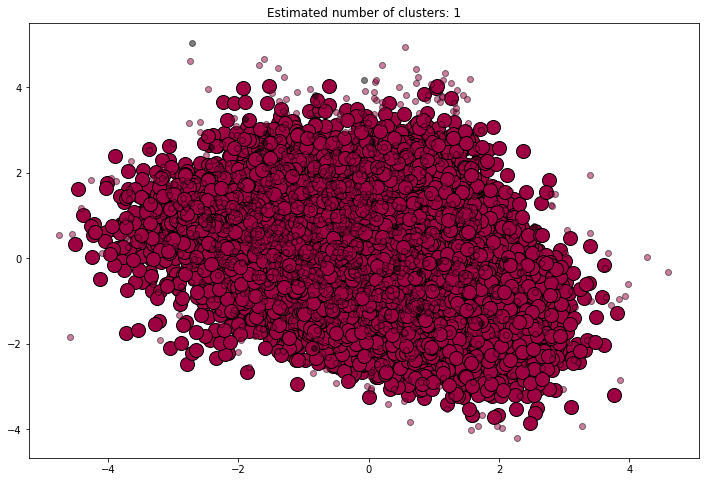

In [27]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot clustering
plot_dbscan(tf_idf_word2vec,labels, n_clusters, core_samples_mask)

<br/>
<br/>
<br/>

---
### Observations :
---

> Note: Several different sizes of dataset were taken to complete the whole task of unsupervised learning,But still we got the complete working of unspervised learning algorithm, which is the whole objective of the task allocated.
> 1. Kmeans and K-Medoids algorithms are performed to cluster similar reviews.
> 2. Nice word clouds of reviews are plotted to identify similar reviews in the cluster.
> 3. In agglomerative clustering, we have chosen different cluster sizes like 2,5  and 10 clusters to group similar reviews, every approach is nicely shown with the help of word clouds.
> 4. DBSCAN algorithm is also performed on the dataset to cluster reviews and show noise as well. 
